In [2]:
%pylab inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


Populating the interactive namespace from numpy and matplotlib


In [3]:
import pickle

In [4]:
from tqdm import tqdm_notebook as tqdm

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [6]:
import scipy

import scipy.constants as sc
hbarc = ( sc.hbar * sc.speed_of_light
         / sc.mega / sc.electron_volt / sc.femto )
ainv = 2.194e3 # lattice cutoff in GeV
lat_unit = hbarc/ainv # lattice spacing in fm

mxi = 0.665 # mass of Xi in lattice unit
mpi = 510/ainv # mass of pion in lattice unit

In [7]:
print(np.__version__)
print(scipy.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.14.2
1.0.0
0.8.1
2.2.2


# import data

In [8]:
ls ../data/potential

pot_1s0_xixi_L64.pkl                 pot_jk_1s0_xixi_L64_exp.pkl
pot_H0term_jk_1s0_xixi_L64_exp.pkl   pot_jk_1s0_xixi_L64_wall.pkl
pot_H0term_jk_1s0_xixi_L64_wall.pkl


In [53]:
v0_lo_jk = {}
for src in ['wall', 'exp']:
    with open(f'../data/potential/pot_jk_1s0_xixi_L64_{src}.pkl', 'rb') as fin:
        _, rs, v0_lo_jk[src] = pickle.load(fin)

In [12]:
ls pkls

n2lo_pot_jk.pkl


In [14]:
with open(f'pkls/n2lo_pot_jk.pkl', 'rb') as fin:
    rs, v0_n2lo_jk, v2_n2lo_jk = pickle.load(fin)

In [15]:
v0_n2lo_jk.keys()

dict_keys([13, 14, 15, 16])

In [16]:
v0_n2lo_jk[13].shape

(20, 6545)

In [45]:
bin_num = v0_n2lo_jk[13].shape[0]

# check data

In [33]:
v0_n2lo_jk[13].shape

(20, 6545)

In [37]:
type(v0_n2lo_jk[13].shape

(20, 6545)

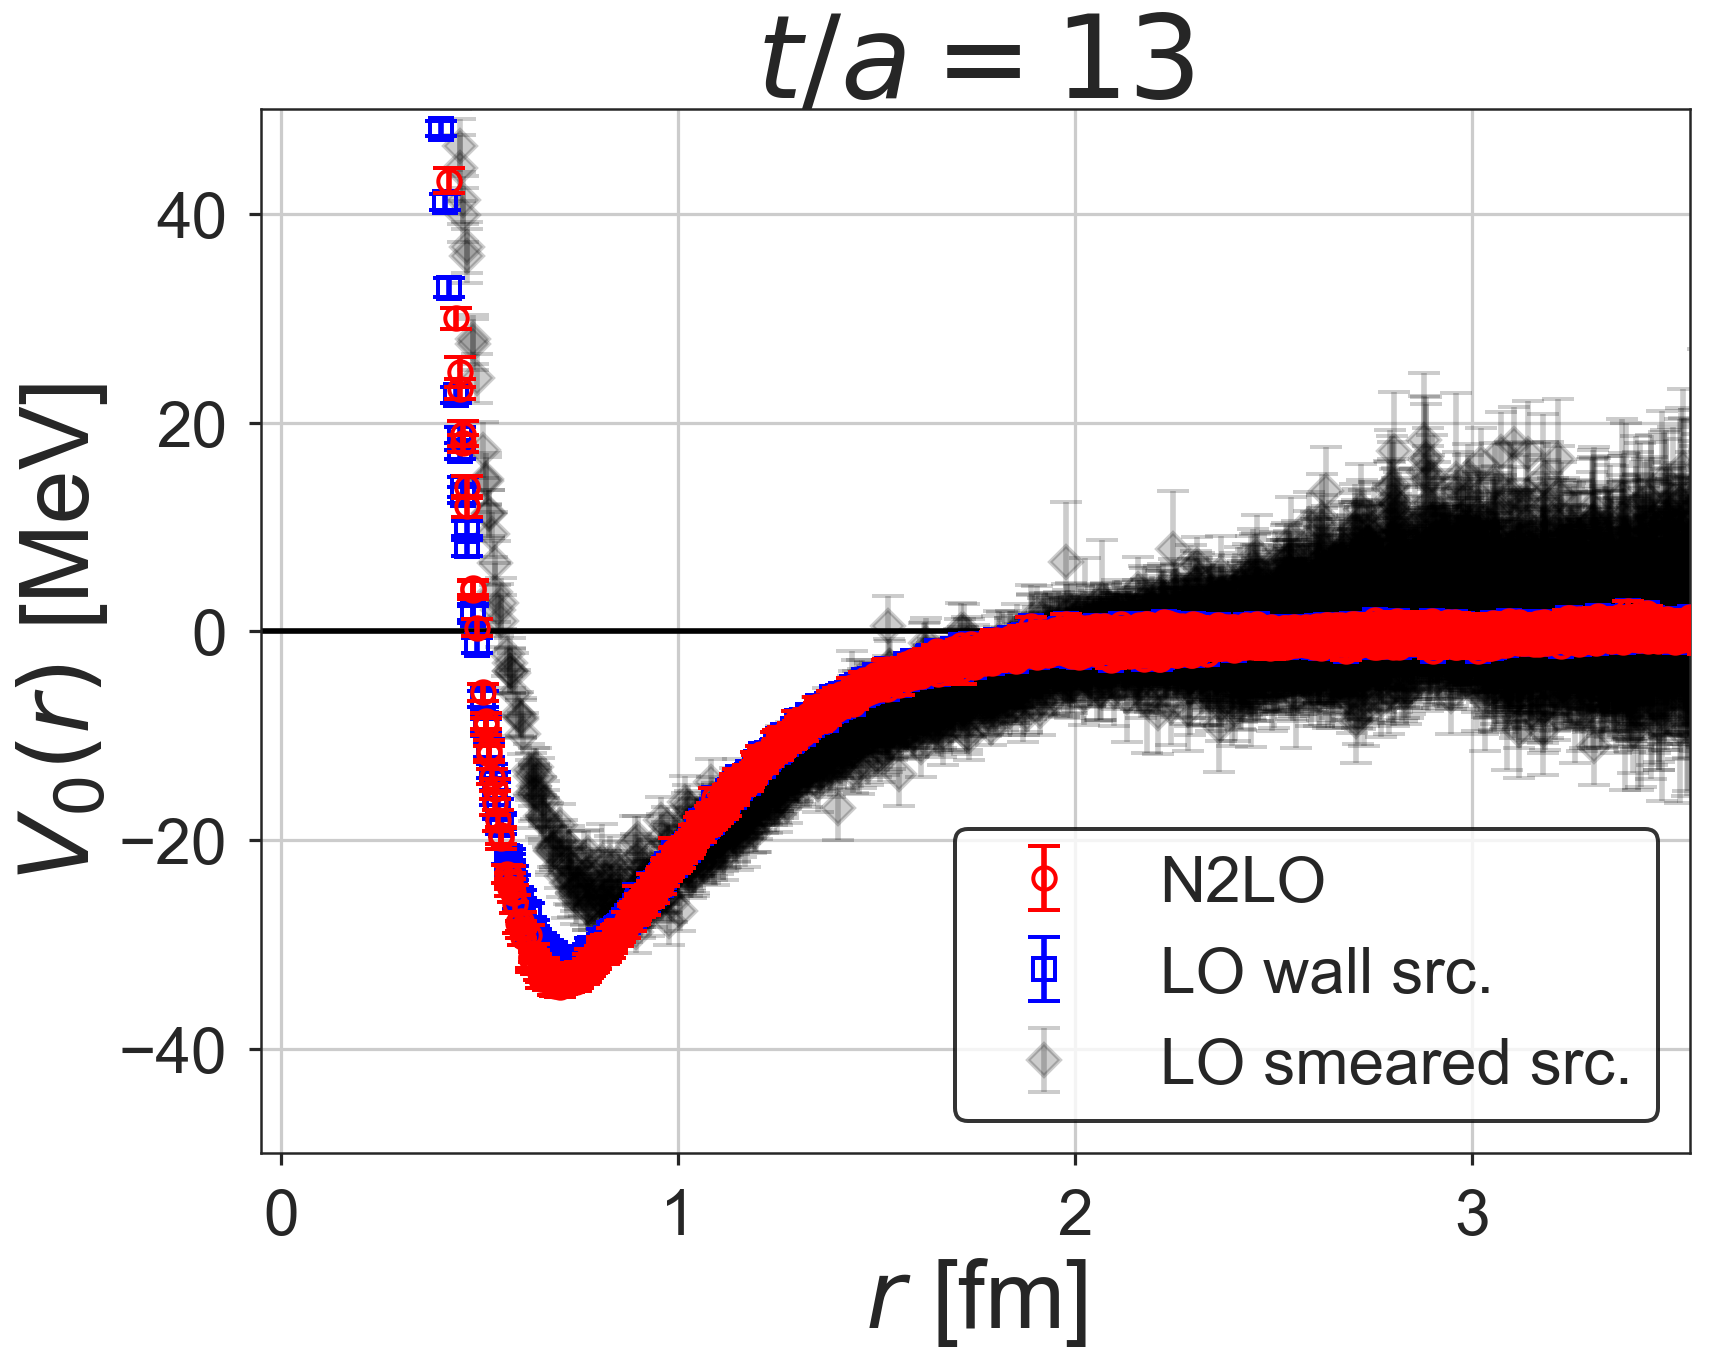

In [62]:
it = 13

fig, ax = plt.subplots()
ax.errorbar(rs * lat_unit, 
            v0_n2lo_jk[it].mean(axis=0) * ainv, 
            v0_n2lo_jk[it].std(axis=0) * np.sqrt(bin_num - 1) * ainv,
            fmt='ro', mfc='none', mec='red', mew=2.0, capsize=8, capthick=2.0,
            label='N2LO', zorder=5)

ax.errorbar(rs * lat_unit, 
            v0_lo_jk['wall'][it].mean(axis=0) * ainv, 
            v0_lo_jk['wall'][it].std(axis=0) * np.sqrt(bin_num - 1) * ainv,
            fmt='bs', mfc='none', mec='blue', mew=2.0, capsize=8, capthick=2.0,
            label='LO wall src.', zorder=3)

ax.errorbar(rs * lat_unit, 
            v0_lo_jk['exp'][it].mean(axis=0) * ainv, 
            v0_lo_jk['exp'][it].std(axis=0) * np.sqrt(bin_num - 1) * ainv,
            fmt='kD', mfc='none', mec='black', mew=2.0, capsize=8, capthick=2.0,
            label='LO smeared src.', zorder=1, alpha=0.2)

ax.set_title(f'$t/a = {it}$', size=58)
ax.grid()
ax.set_ylim(-50, 50)
ax.set_xlim(-0.05, 3.55)
ax.axhline(0, color='black')
ax.set_ylabel(r'$V_0(r)$ [MeV]', size=48)
ax.set_xlabel(r'$r$ [fm]', size=48)

leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

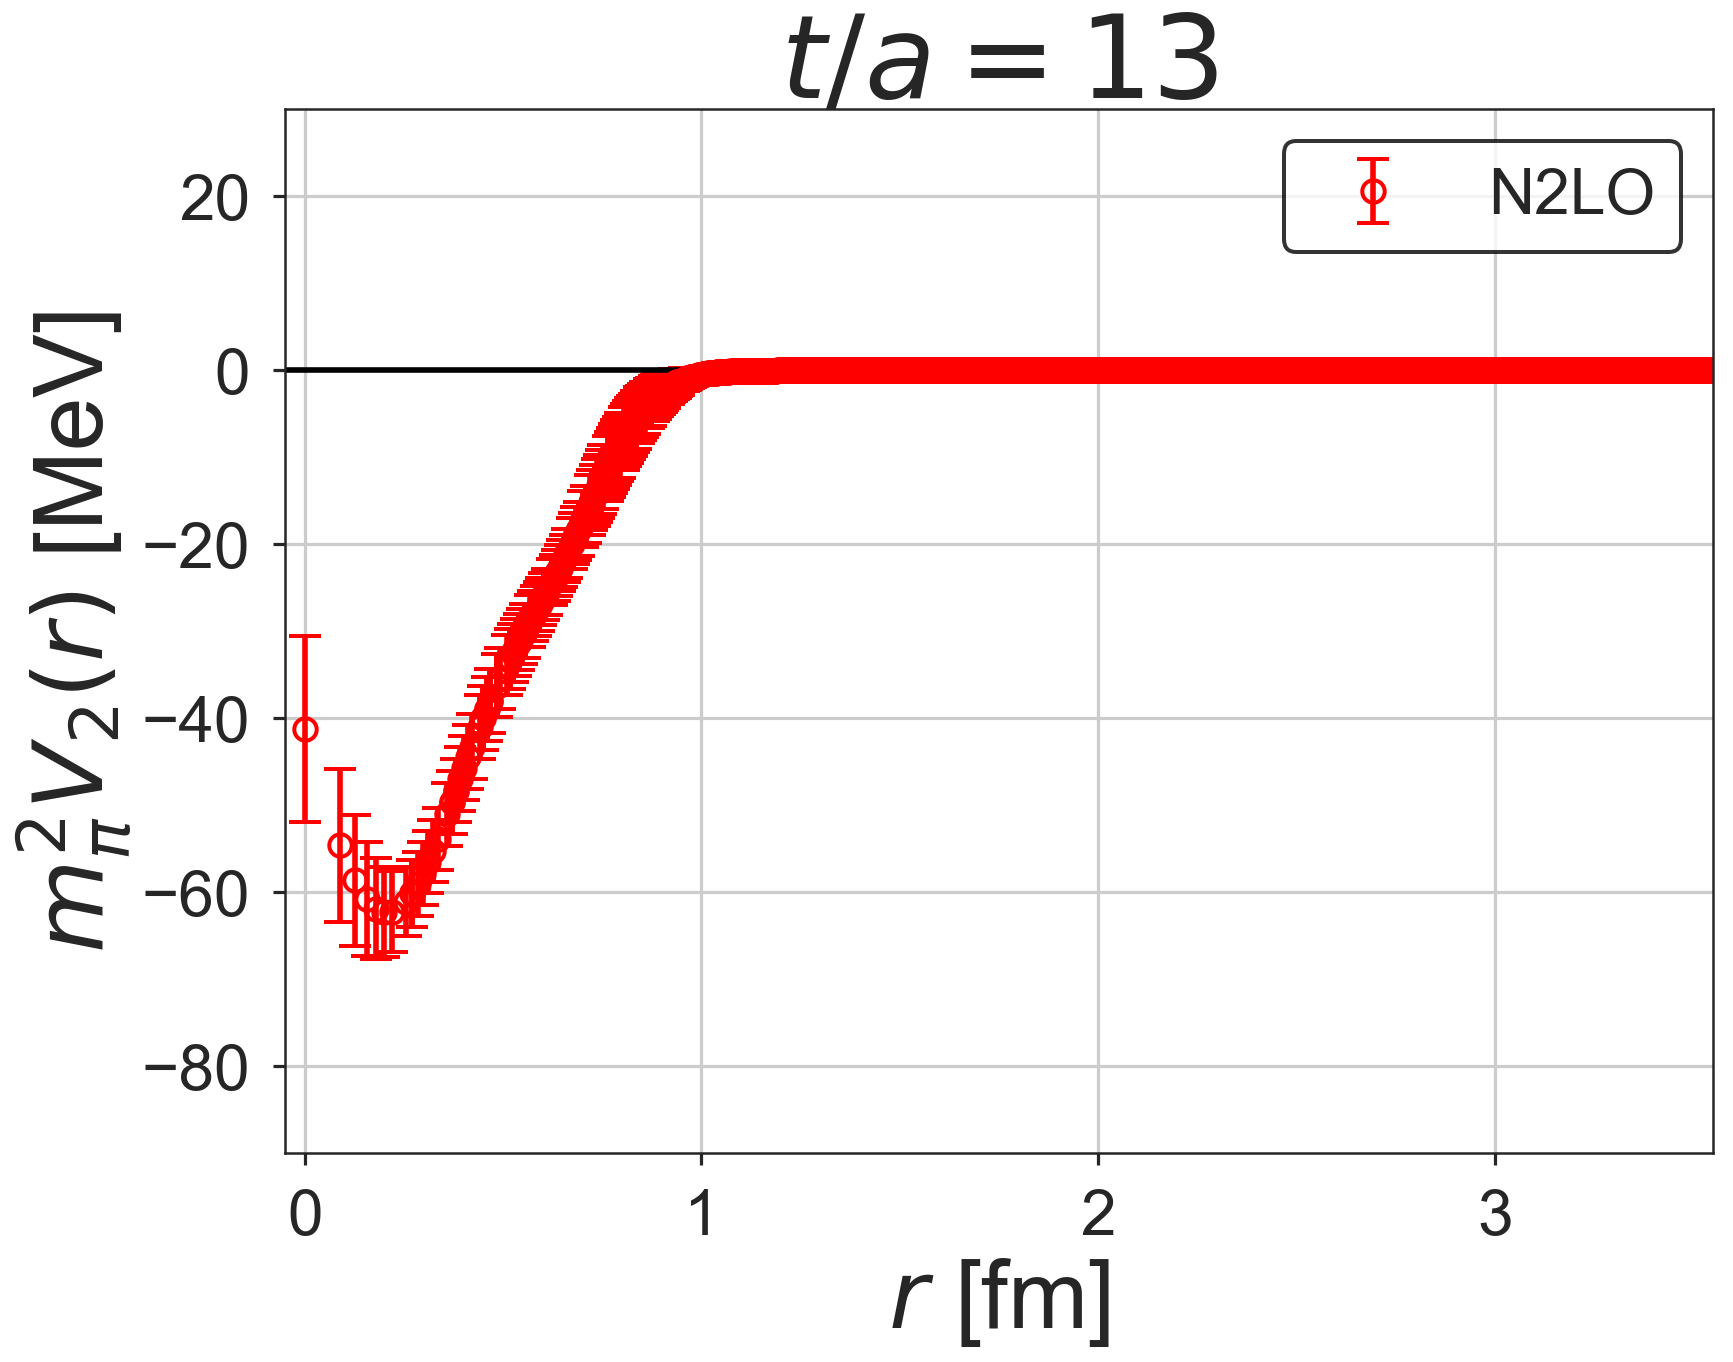

In [63]:
it = 13

fig, ax = plt.subplots()
ax.errorbar(rs * lat_unit, 
            v2_n2lo_jk[it].mean(axis=0) * mpi**2 * ainv, 
            v2_n2lo_jk[it].std(axis=0) * np.sqrt(bin_num - 1) * mpi**2 * ainv,
            fmt='ro', mfc='none', mec='red', mew=2.0, capsize=8, capthick=2.0,
            label='N2LO')

ax.set_title(f'$t/a = {it}$', size=58)
ax.grid()
ax.set_ylim(-90, 30)
ax.set_xlim(-0.05, 3.55)
ax.axhline(0, color='black')
ax.set_ylabel(r'$m_\pi^2 V_2(r)$ [MeV]', size=48)
ax.set_xlabel(r'$r$ [fm]', size=48)

leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

# Fitting

In [70]:
def pot_fit(xs, ys, yerrs, vfit, p0, rmax=3.5/lat_unit, rmin=0.0):
    """
    xs : r
    ys : potential 
    yerrs : error of potential
    vfit : fit function
    p0 : initial parameter
    """
    mask = (xs >= rmin) & (xs <= rmax)
    errf = lambda p, y, x, err : (vfit(p,x) - y)/err
    
    pfit = scipy.optimize.leastsq(errf, p0, args=(ys[mask], xs[mask], yerrs[mask]),
                                 full_output=True)
    dof = len(xs[mask]) - len(p0)
    chisq = sum(pfit[2]['fvec']**2)
    
    return pfit[0], dof, chisq

In [74]:
V4gauss = lambda p, x: (p[0]*np.exp(-p[1]*x**2) + p[2]*np.exp(-p[3]*x**2)
                        + p[4]*np.exp(-p[5]*x**2) + p[6]*np.exp(-p[7]*x**2))
                        
V2gauss = lambda p, x: p[0]*np.exp(-p[1]*(x-p[2])**2) + p[3]*np.exp(-p[4]*(x-p[5])**2)

In [68]:
p0_V4gauss = np.array([ 0.84479193,  0.80043474,
               0.28222412,  0.20486377,
               0.16196509,  0.06677487,
              -0.03015106,  0.00911472])

In [81]:
def pot_4gauss_fit(pot_jk):
    xs = rs
    ys = pot_jk.mean(axis=0)
    yerrs = pot_jk.std(axis=0) * np.sqrt(bin_num)
    p0, dof, chisq = pot_fit(xs, ys, yerrs, V4gauss, p0_V4gauss)
    print(f'av chisq/dof = {chisq/dof:3.2f}')
    prm_4gauss_av = p0
    prm_tmps = []
    for ibin in range(bin_num):
        ys = pot_jk[ibin,:]
        prm_tmp, dof, chisq = pot_fit(xs, ys, yerrs, V4gauss, p0)
        prm_tmps.append(prm_tmp)
        print(f'{ibin} chisq/dof = {chisq/dof:3.2f}')

    prm_4gauss_jk = np.array(prm_tmps)
        
    return prm_4gauss_av, prm_4gauss_jk

In [82]:
prm_4gauss_avs = {}
prm_4gauss_jks = {}

In [84]:
for it in [13, 14, 15, 16]:
    print(f'# t = {it}')
    prm_4gauss_avs[('n2lo', it)], prm_4gauss_jks[('n2lo', it)] = pot_4gauss_fit(v0_n2lo_jk[it])

# t = 13
av chisq/dof = 0.96
0 chisq/dof = 0.92
1 chisq/dof = 1.04
2 chisq/dof = 0.97
3 chisq/dof = 1.11
4 chisq/dof = 1.08
5 chisq/dof = 1.10
6 chisq/dof = 1.07
7 chisq/dof = 0.99
8 chisq/dof = 0.98
9 chisq/dof = 1.00
10 chisq/dof = 0.77
11 chisq/dof = 0.98
12 chisq/dof = 0.97
13 chisq/dof = 0.97
14 chisq/dof = 1.03
15 chisq/dof = 0.93
16 chisq/dof = 1.05
17 chisq/dof = 0.93
18 chisq/dof = 1.06
19 chisq/dof = 1.12
# t = 14
av chisq/dof = 0.90
0 chisq/dof = 0.87
1 chisq/dof = 0.96
2 chisq/dof = 0.99
3 chisq/dof = 1.03
4 chisq/dof = 1.07
5 chisq/dof = 0.99
6 chisq/dof = 0.91
7 chisq/dof = 0.96
8 chisq/dof = 0.97
9 chisq/dof = 0.99
10 chisq/dof = 0.75
11 chisq/dof = 0.92
12 chisq/dof = 0.88
13 chisq/dof = 0.88
14 chisq/dof = 0.94
15 chisq/dof = 0.90
16 chisq/dof = 0.96
17 chisq/dof = 0.89
18 chisq/dof = 0.98
19 chisq/dof = 1.04
# t = 15
av chisq/dof = 1.00
0 chisq/dof = 1.01
1 chisq/dof = 1.01
2 chisq/dof = 1.05
3 chisq/dof = 1.05
4 chisq/dof = 1.11
5 chisq/dof = 1.08
6 chisq/dof = 1.03


In [85]:
v0_lo_jk.keys()

dict_keys(['wall', 'exp'])

In [86]:
for it in [13, 14, 15, 16]:
    print(f'# t = {it}')
    prm_4gauss_avs[('wall', it)], prm_4gauss_jks[('wall', it)] = pot_4gauss_fit(v0_lo_jk['wall'][it])

# t = 13
av chisq/dof = 1.09
0 chisq/dof = 1.05
1 chisq/dof = 1.16
2 chisq/dof = 1.10
3 chisq/dof = 1.23
4 chisq/dof = 1.21
5 chisq/dof = 1.23
6 chisq/dof = 1.19
7 chisq/dof = 1.12
8 chisq/dof = 1.10
9 chisq/dof = 1.13
10 chisq/dof = 0.91
11 chisq/dof = 1.11
12 chisq/dof = 1.10
13 chisq/dof = 1.10
14 chisq/dof = 1.16
15 chisq/dof = 1.06
16 chisq/dof = 1.17
17 chisq/dof = 1.06
18 chisq/dof = 1.19
19 chisq/dof = 1.25
# t = 14
av chisq/dof = 0.97
0 chisq/dof = 0.94
1 chisq/dof = 1.03
2 chisq/dof = 1.06
3 chisq/dof = 1.11
4 chisq/dof = 1.15
5 chisq/dof = 1.06
6 chisq/dof = 0.98
7 chisq/dof = 1.03
8 chisq/dof = 1.04
9 chisq/dof = 1.06
10 chisq/dof = 0.83
11 chisq/dof = 1.00
12 chisq/dof = 0.95
13 chisq/dof = 0.95
14 chisq/dof = 1.02
15 chisq/dof = 0.97
16 chisq/dof = 1.03
17 chisq/dof = 0.96
18 chisq/dof = 1.06
19 chisq/dof = 1.11
# t = 15
av chisq/dof = 1.04
0 chisq/dof = 1.05
1 chisq/dof = 1.05
2 chisq/dof = 1.08
3 chisq/dof = 1.10
4 chisq/dof = 1.15
5 chisq/dof = 1.12
6 chisq/dof = 1.07


In [87]:
for it in [13, 14, 15, 16]:
    print(f'# t = {it}')
    prm_4gauss_avs[('exp', it)], prm_4gauss_jks[('exp', it)] = pot_4gauss_fit(v0_lo_jk['exp'][it])

# t = 13
av chisq/dof = 1.04
0 chisq/dof = 1.10
1 chisq/dof = 1.07
2 chisq/dof = 1.08
3 chisq/dof = 1.09
4 chisq/dof = 1.09
5 chisq/dof = 1.04
6 chisq/dof = 1.03
7 chisq/dof = 1.07
8 chisq/dof = 1.05
9 chisq/dof = 1.01
10 chisq/dof = 1.15
11 chisq/dof = 1.15
12 chisq/dof = 1.15
13 chisq/dof = 1.19
14 chisq/dof = 1.11
15 chisq/dof = 1.04
16 chisq/dof = 1.09
17 chisq/dof = 1.10
18 chisq/dof = 1.10
19 chisq/dof = 0.99
# t = 14
av chisq/dof = 1.16
0 chisq/dof = 1.27
1 chisq/dof = 1.17
2 chisq/dof = 1.18
3 chisq/dof = 1.17
4 chisq/dof = 1.23
5 chisq/dof = 1.16
6 chisq/dof = 1.16
7 chisq/dof = 1.20
8 chisq/dof = 1.17
9 chisq/dof = 1.18
10 chisq/dof = 1.32
11 chisq/dof = 1.33
12 chisq/dof = 1.21
13 chisq/dof = 1.27
14 chisq/dof = 1.25
15 chisq/dof = 1.15
16 chisq/dof = 1.14
17 chisq/dof = 1.21
18 chisq/dof = 1.27
19 chisq/dof = 1.14
# t = 15
av chisq/dof = 1.27
0 chisq/dof = 1.36
1 chisq/dof = 1.31
2 chisq/dof = 1.31
3 chisq/dof = 1.36
4 chisq/dof = 1.34
5 chisq/dof = 1.27
6 chisq/dof = 1.26


## check V0 fitting

In [88]:
V4gauss?

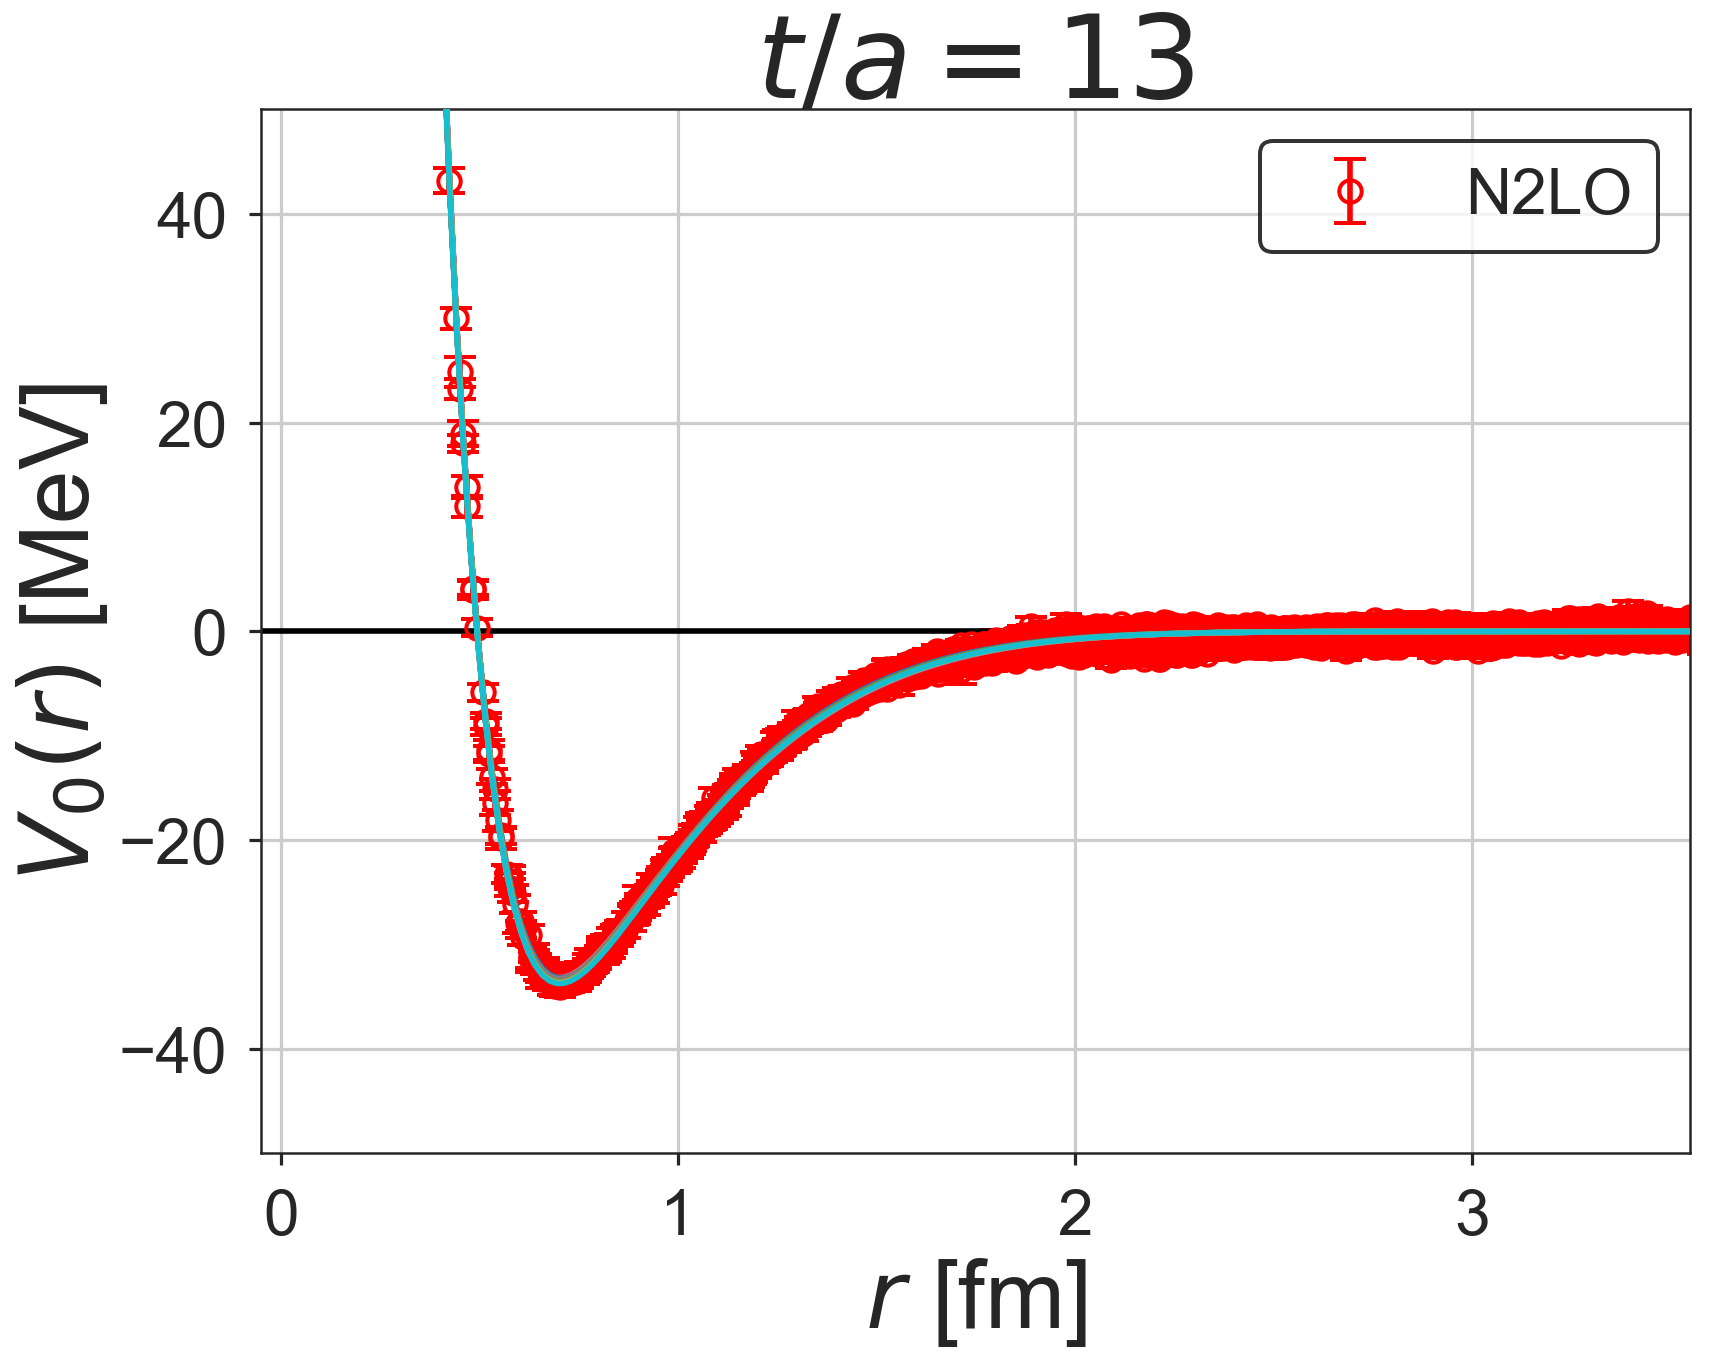

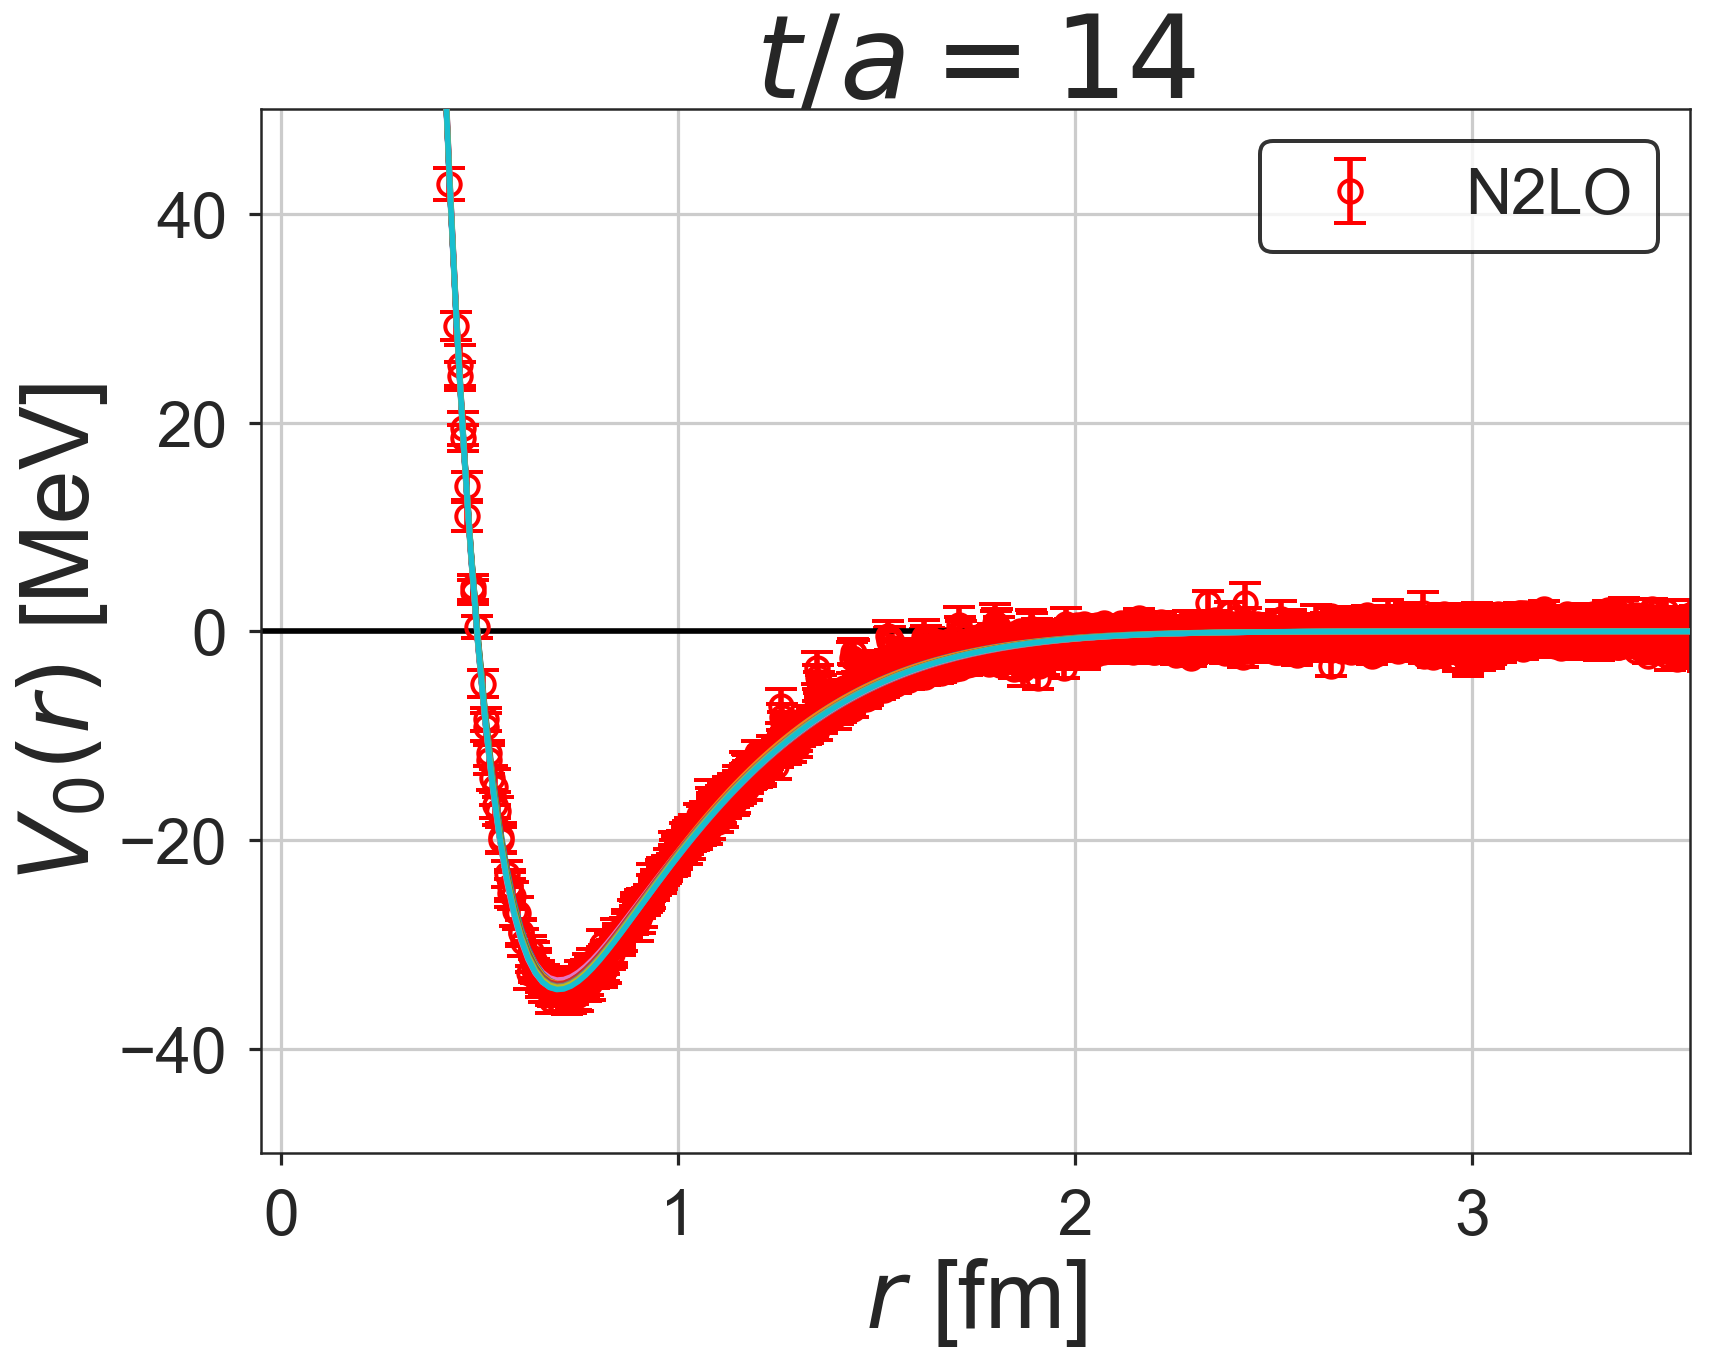

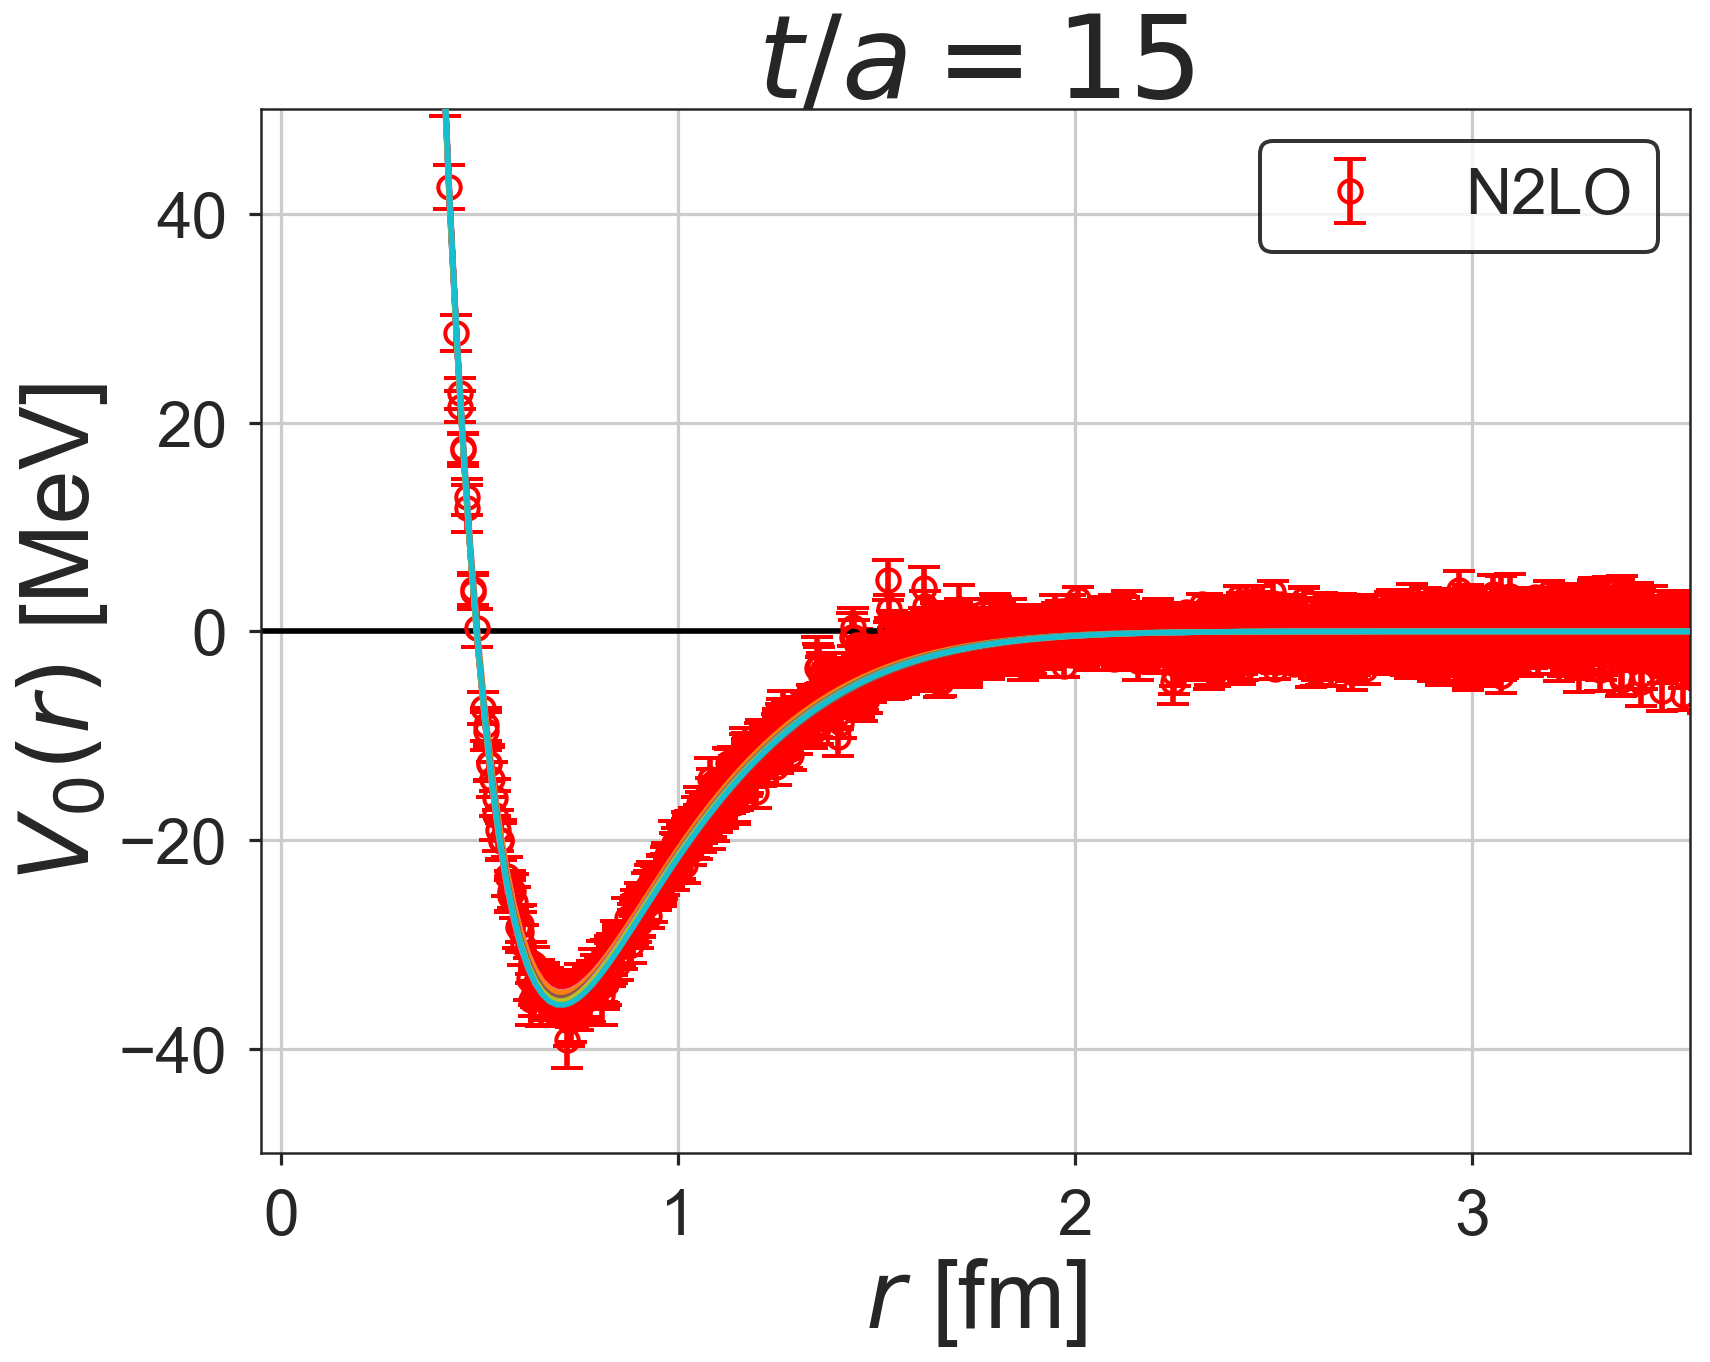

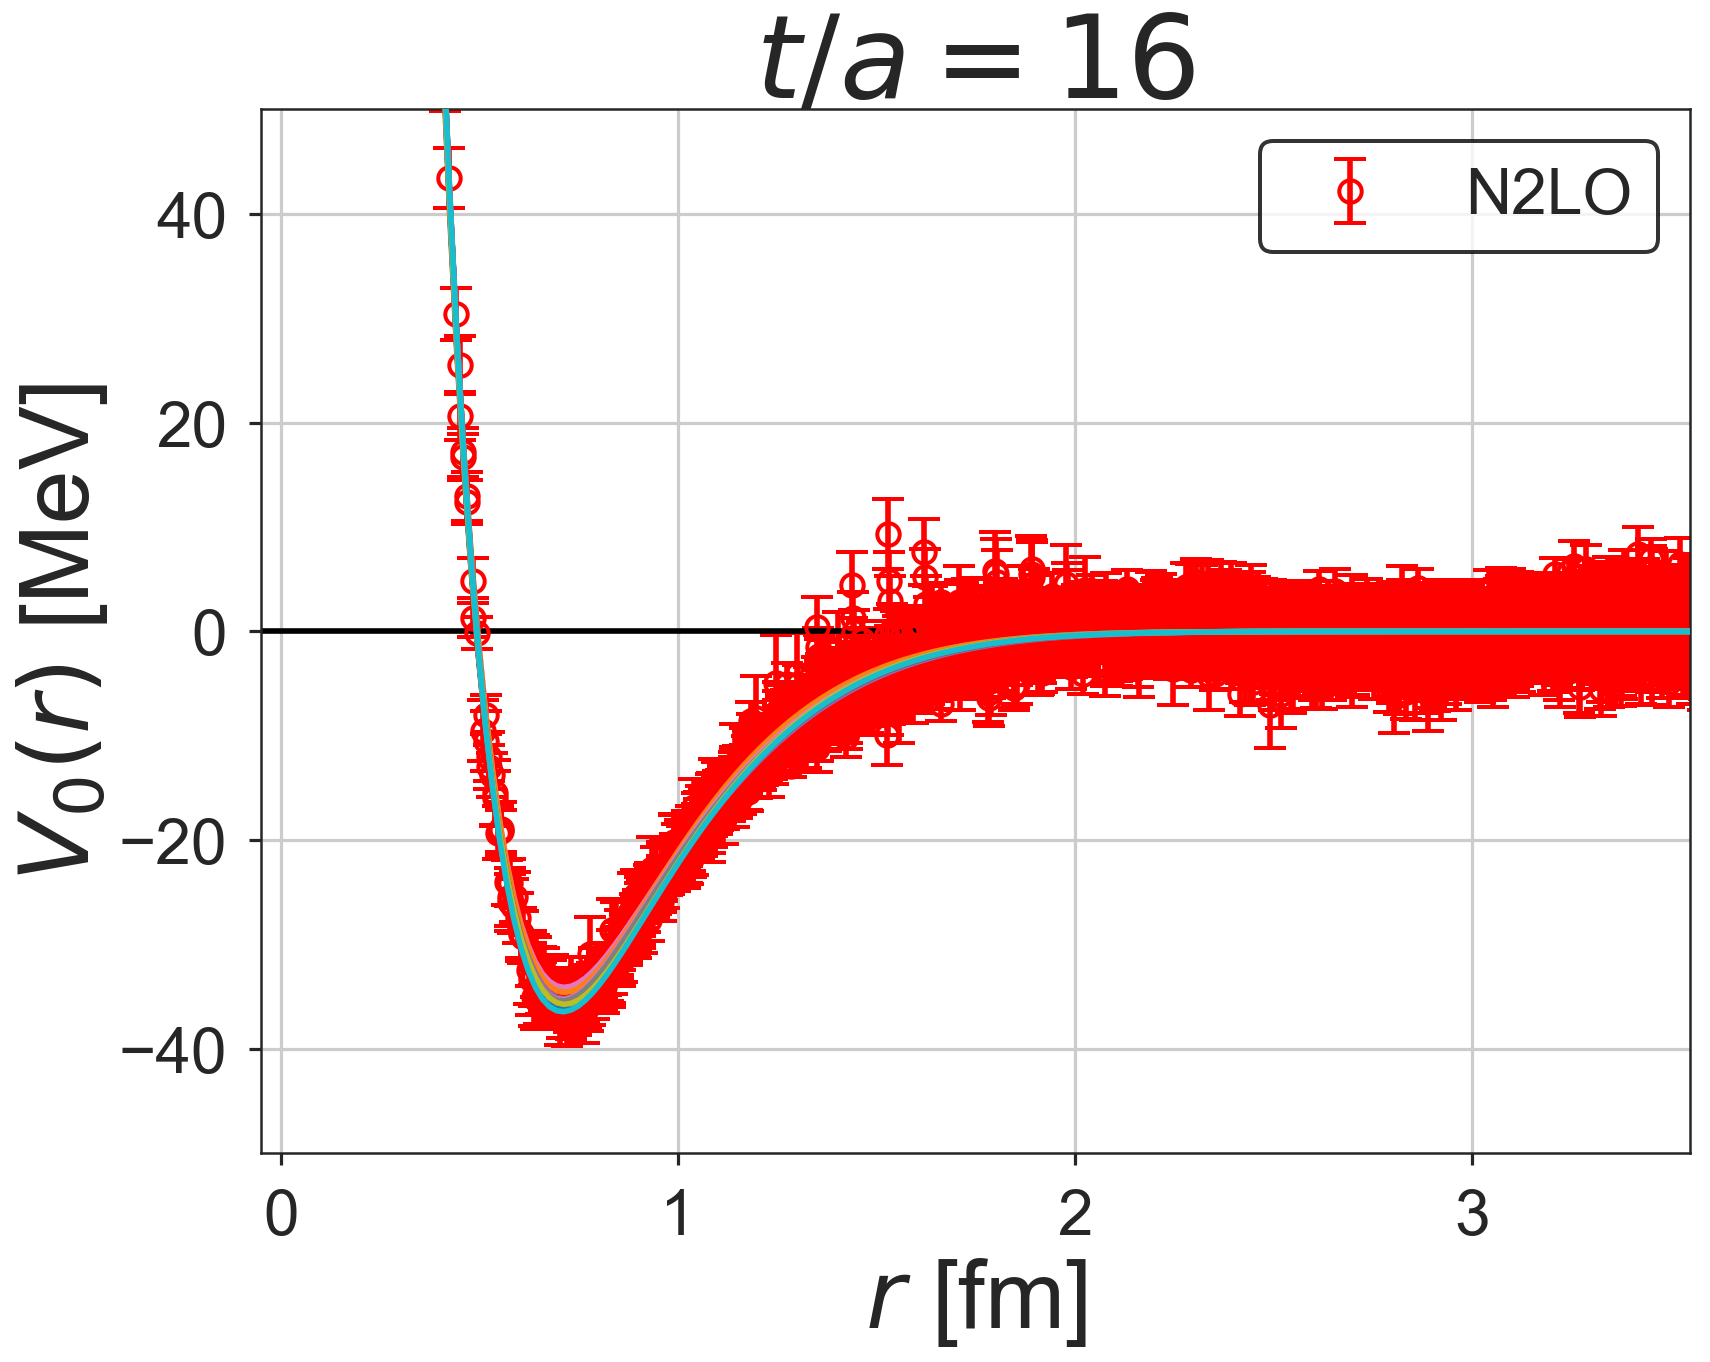

In [111]:
def check_v0_n2lo_fitting(it):
    fig, ax = plt.subplots()
    ax.errorbar(rs * lat_unit, 
                v0_n2lo_jk[it].mean(axis=0) * ainv, 
                v0_n2lo_jk[it].std(axis=0) * np.sqrt(bin_num - 1) * ainv,
                fmt='ro', mfc='none', mec='red', mew=2.0, capsize=8, capthick=2.0,
                label='N2LO')

    p0 = prm_4gauss_avs[('n2lo', it)]
    xls = np.linspace(1.0e-1, 40, 200)
    ax.plot(xls * lat_unit, V4gauss(p0,xls) * ainv, color='black', zorder=5) 

    for ibin in range(bin_num):
        p0 = prm_4gauss_jks[('n2lo', it)][ibin,:]
        ax.plot(xls * lat_unit, V4gauss(p0,xls) * ainv, zorder=5) 

    ax.set_title(f'$t/a = {it}$', size=58)
    ax.grid()
    ax.set_ylim(-50, 50)
    ax.set_xlim(-0.05, 3.55)
    ax.axhline(0, color='black')
    ax.set_ylabel(r'$V_0(r)$ [MeV]', size=48)
    ax.set_xlabel(r'$r$ [fm]', size=48)

    leg = ax.legend(frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    
for it in [13, 14, 15, 16]:
    check_v0_n2lo_fitting(it)

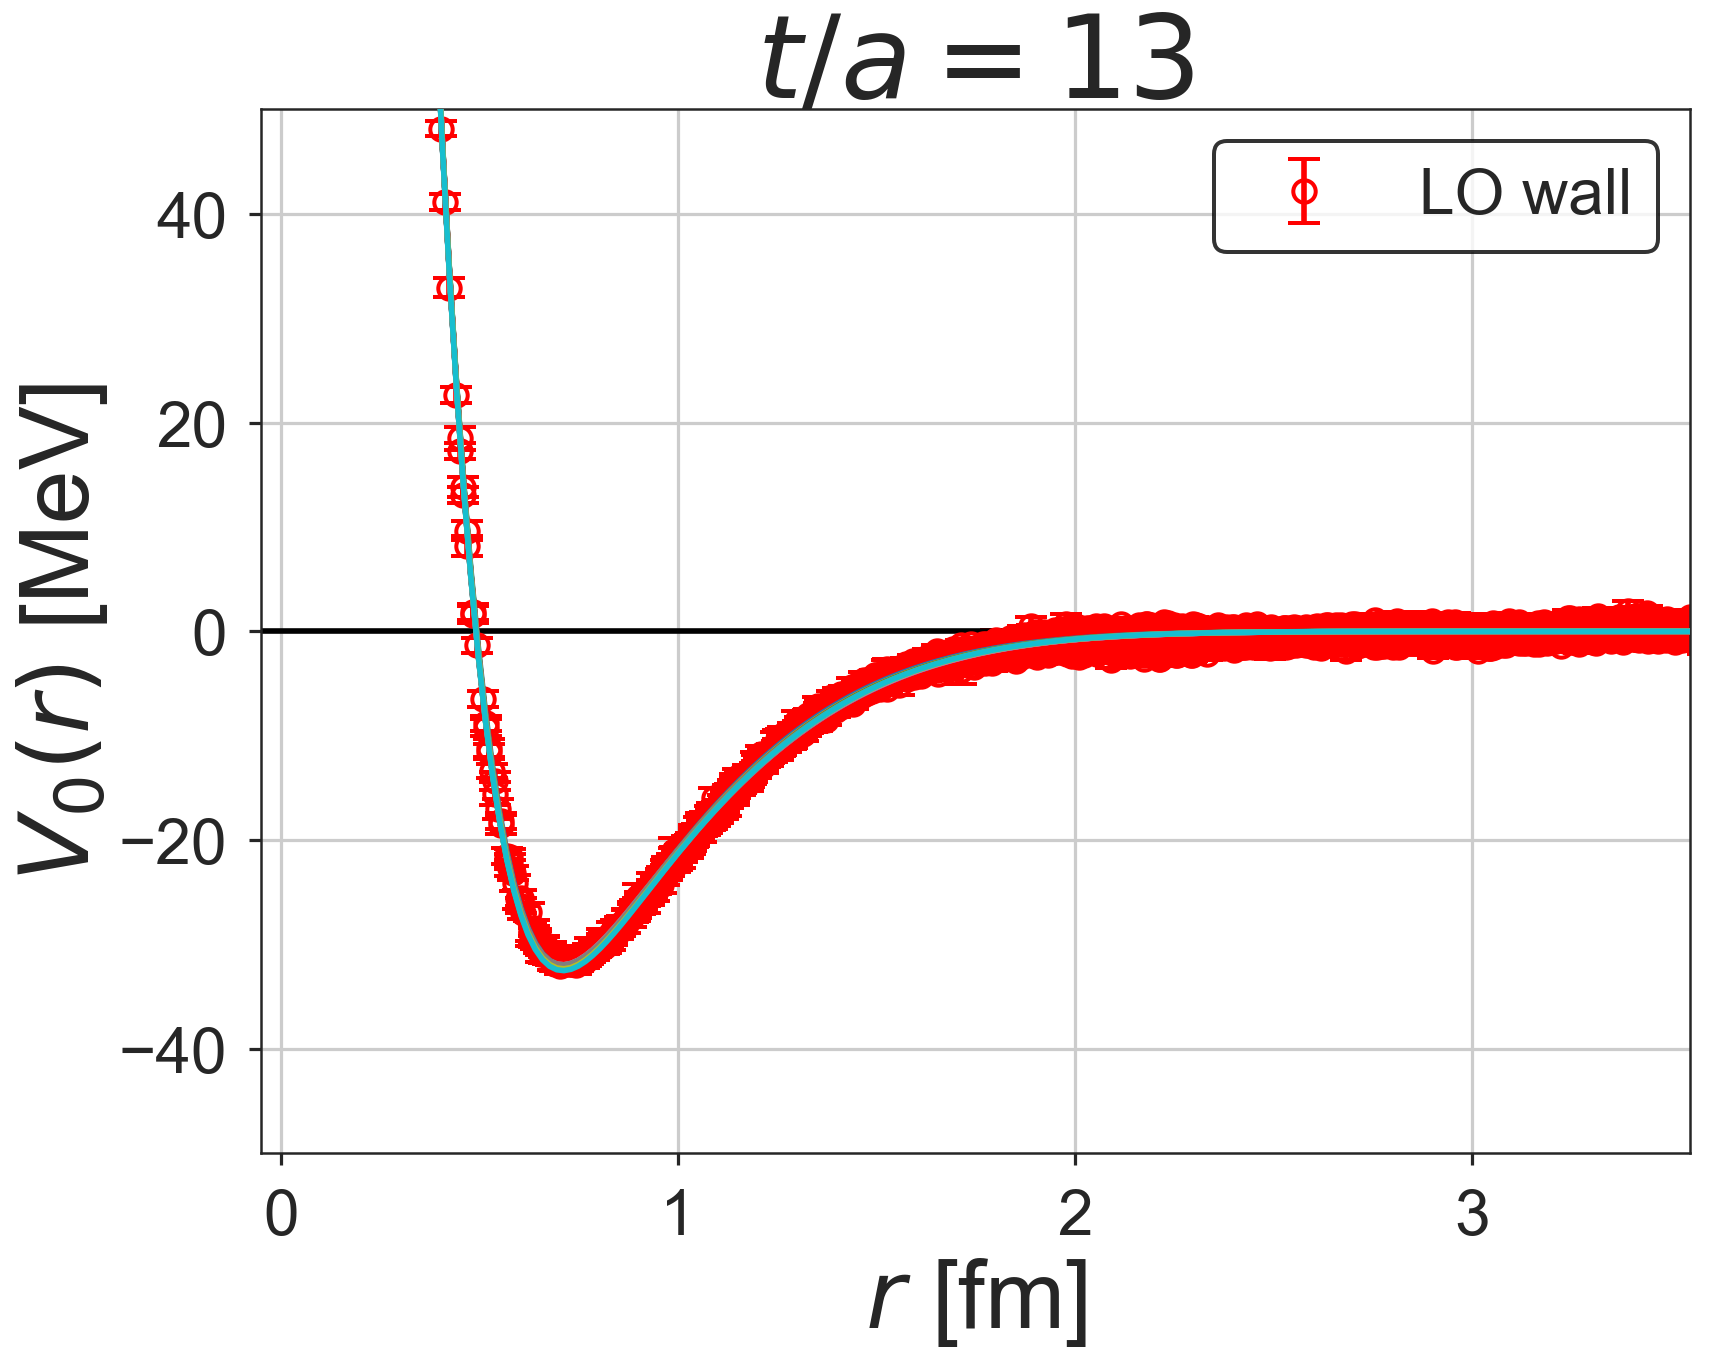

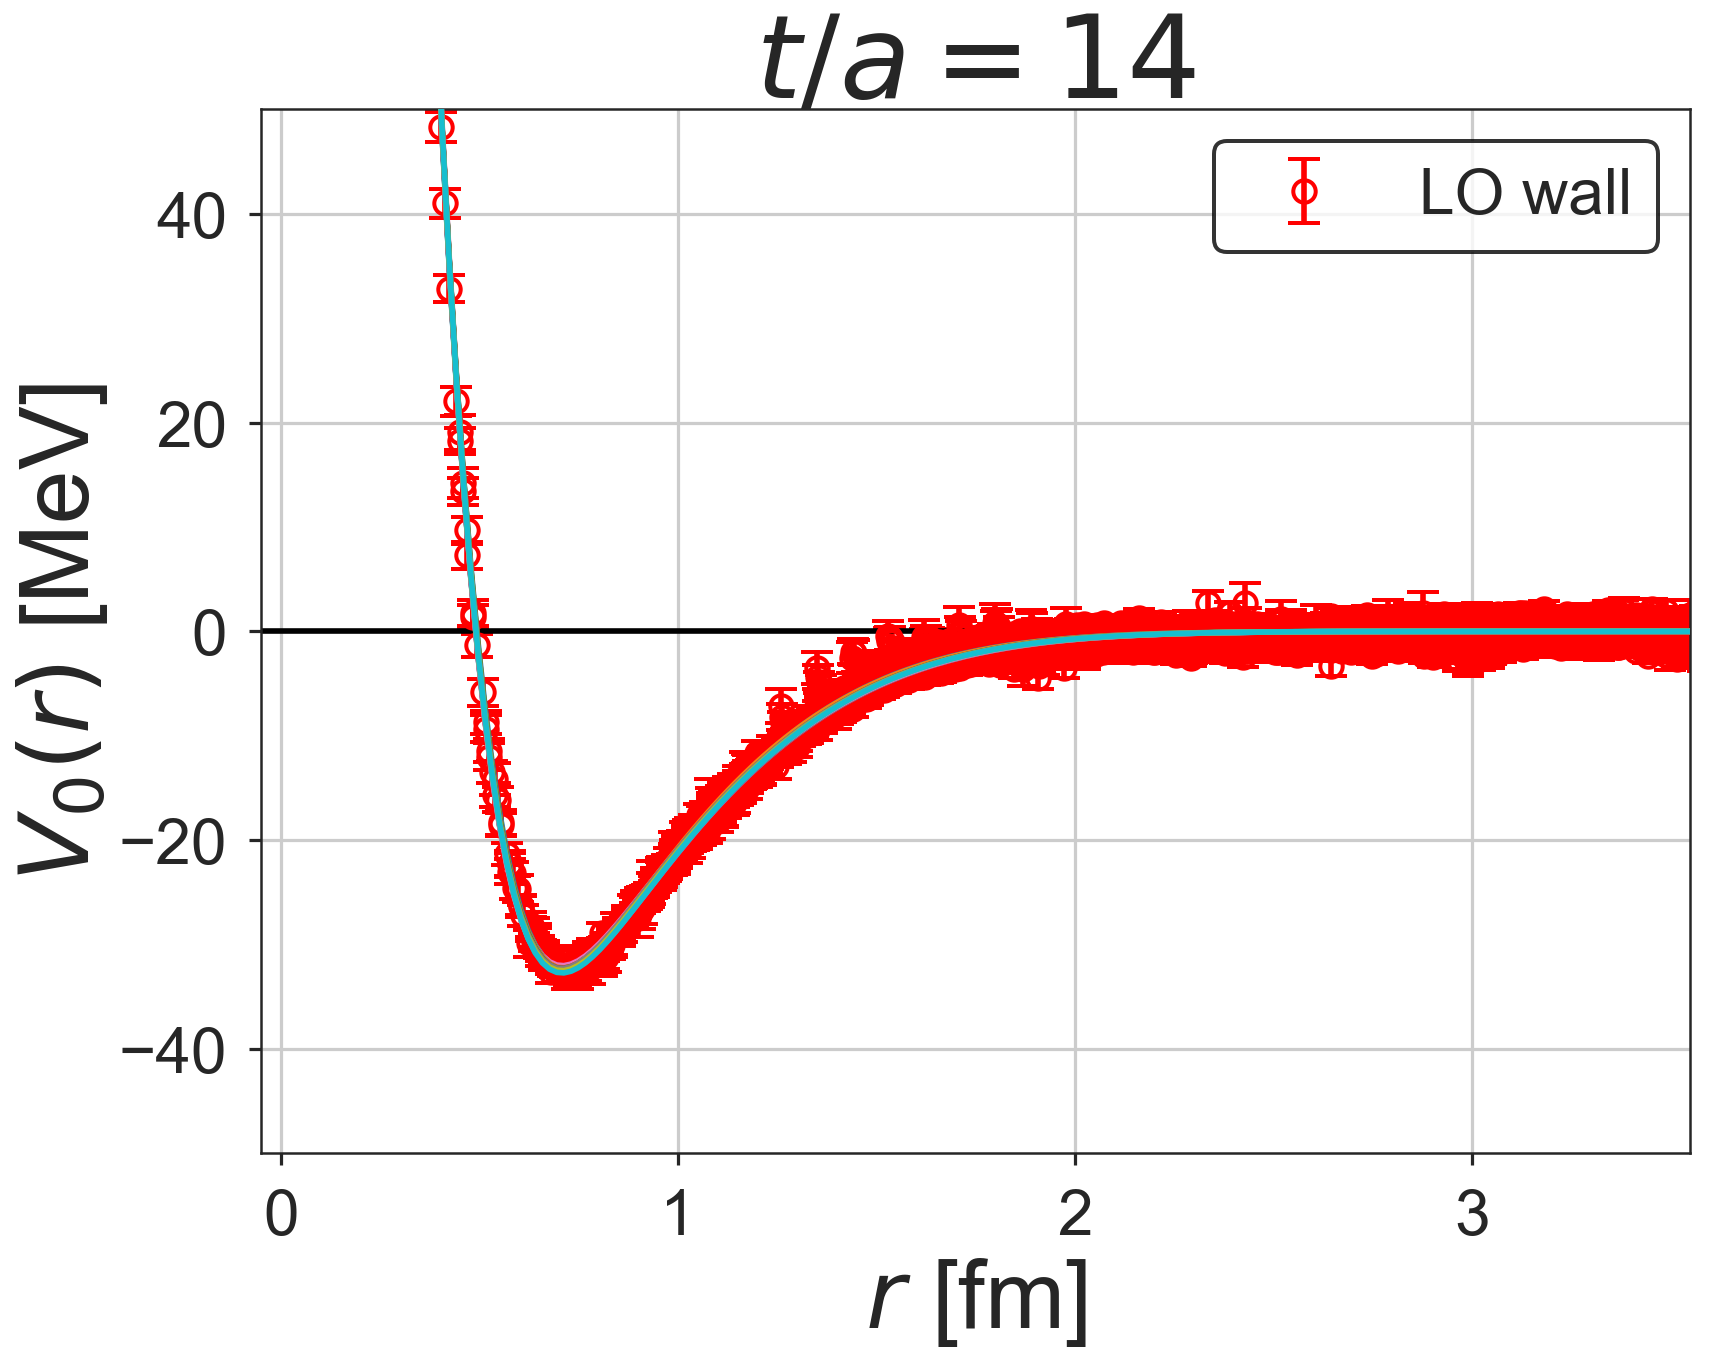

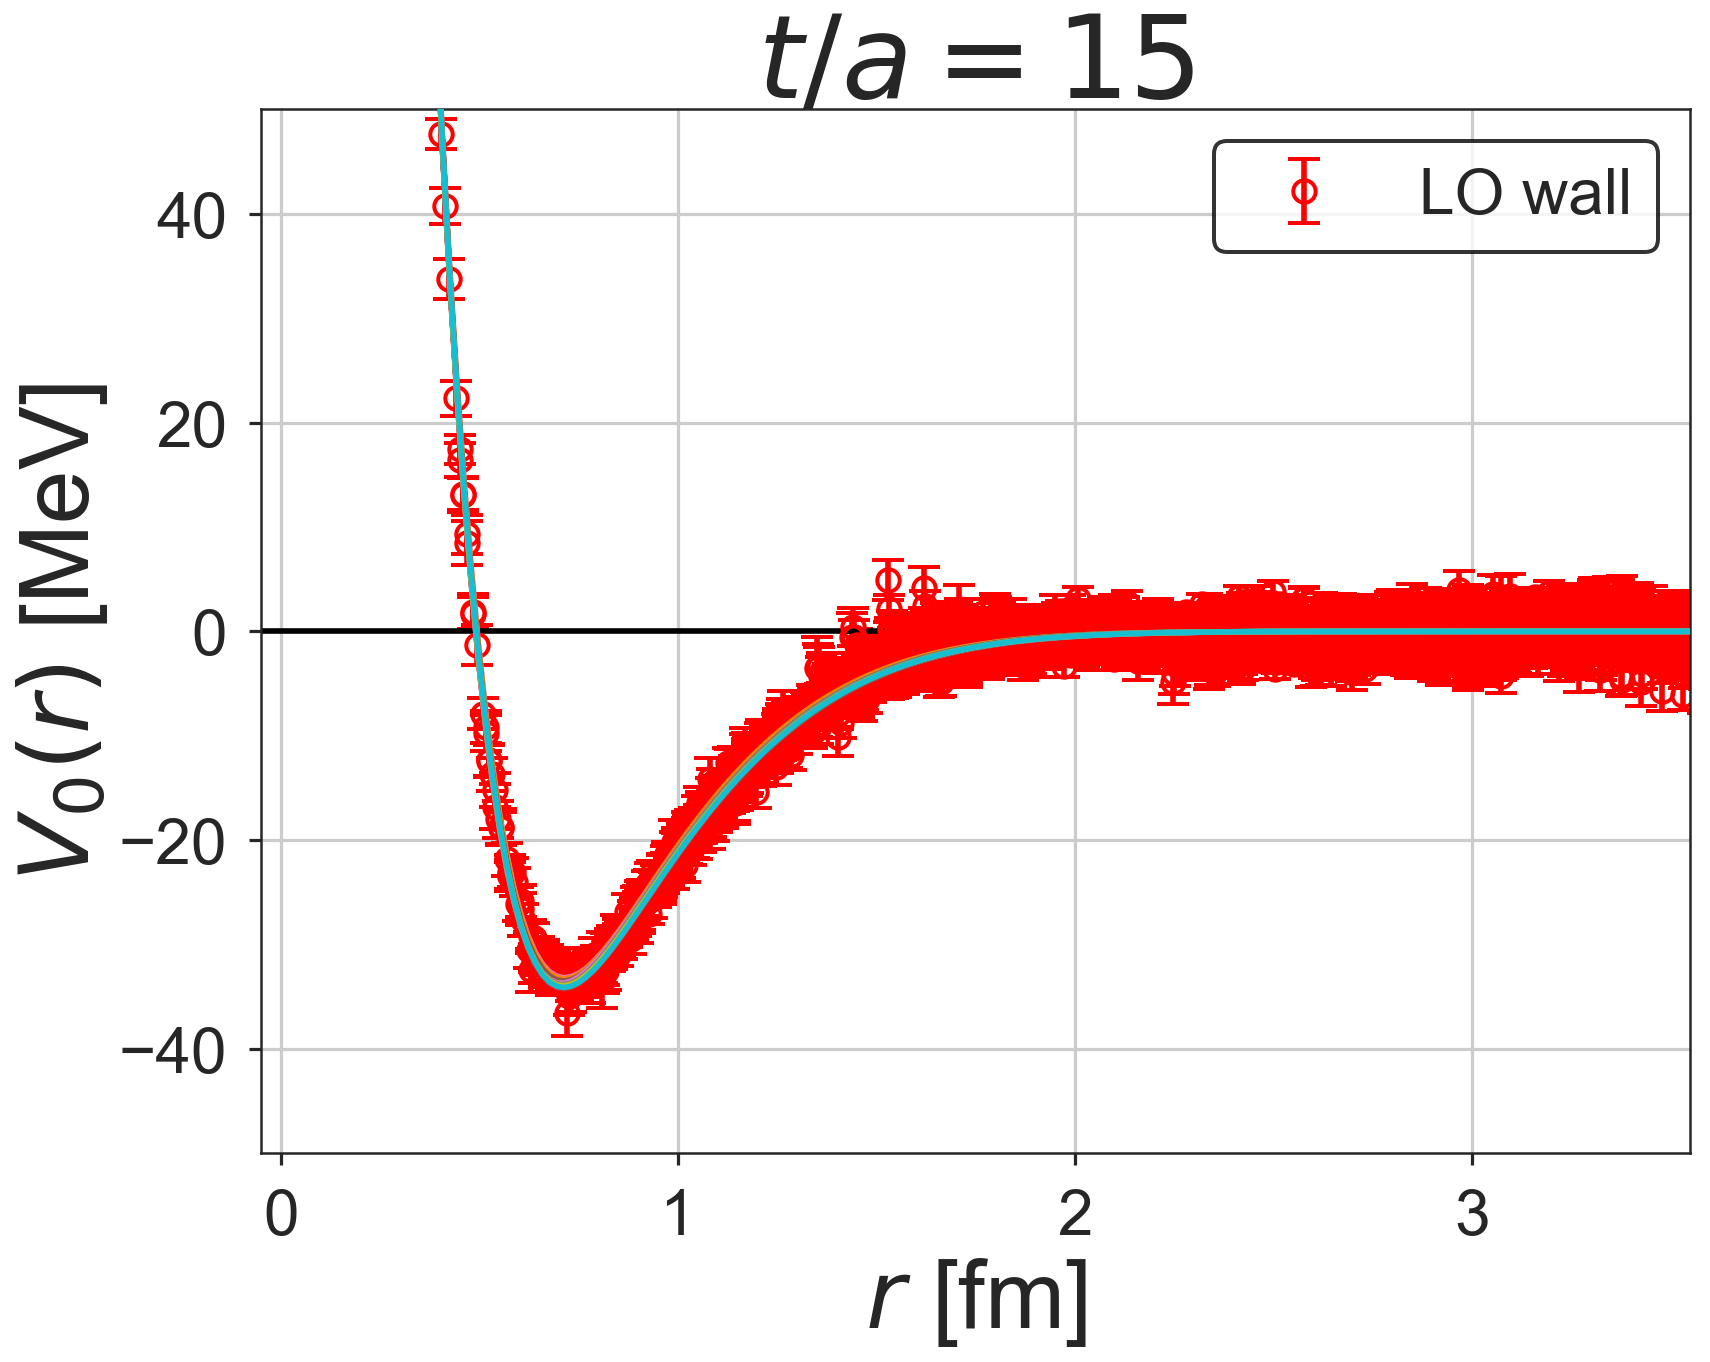

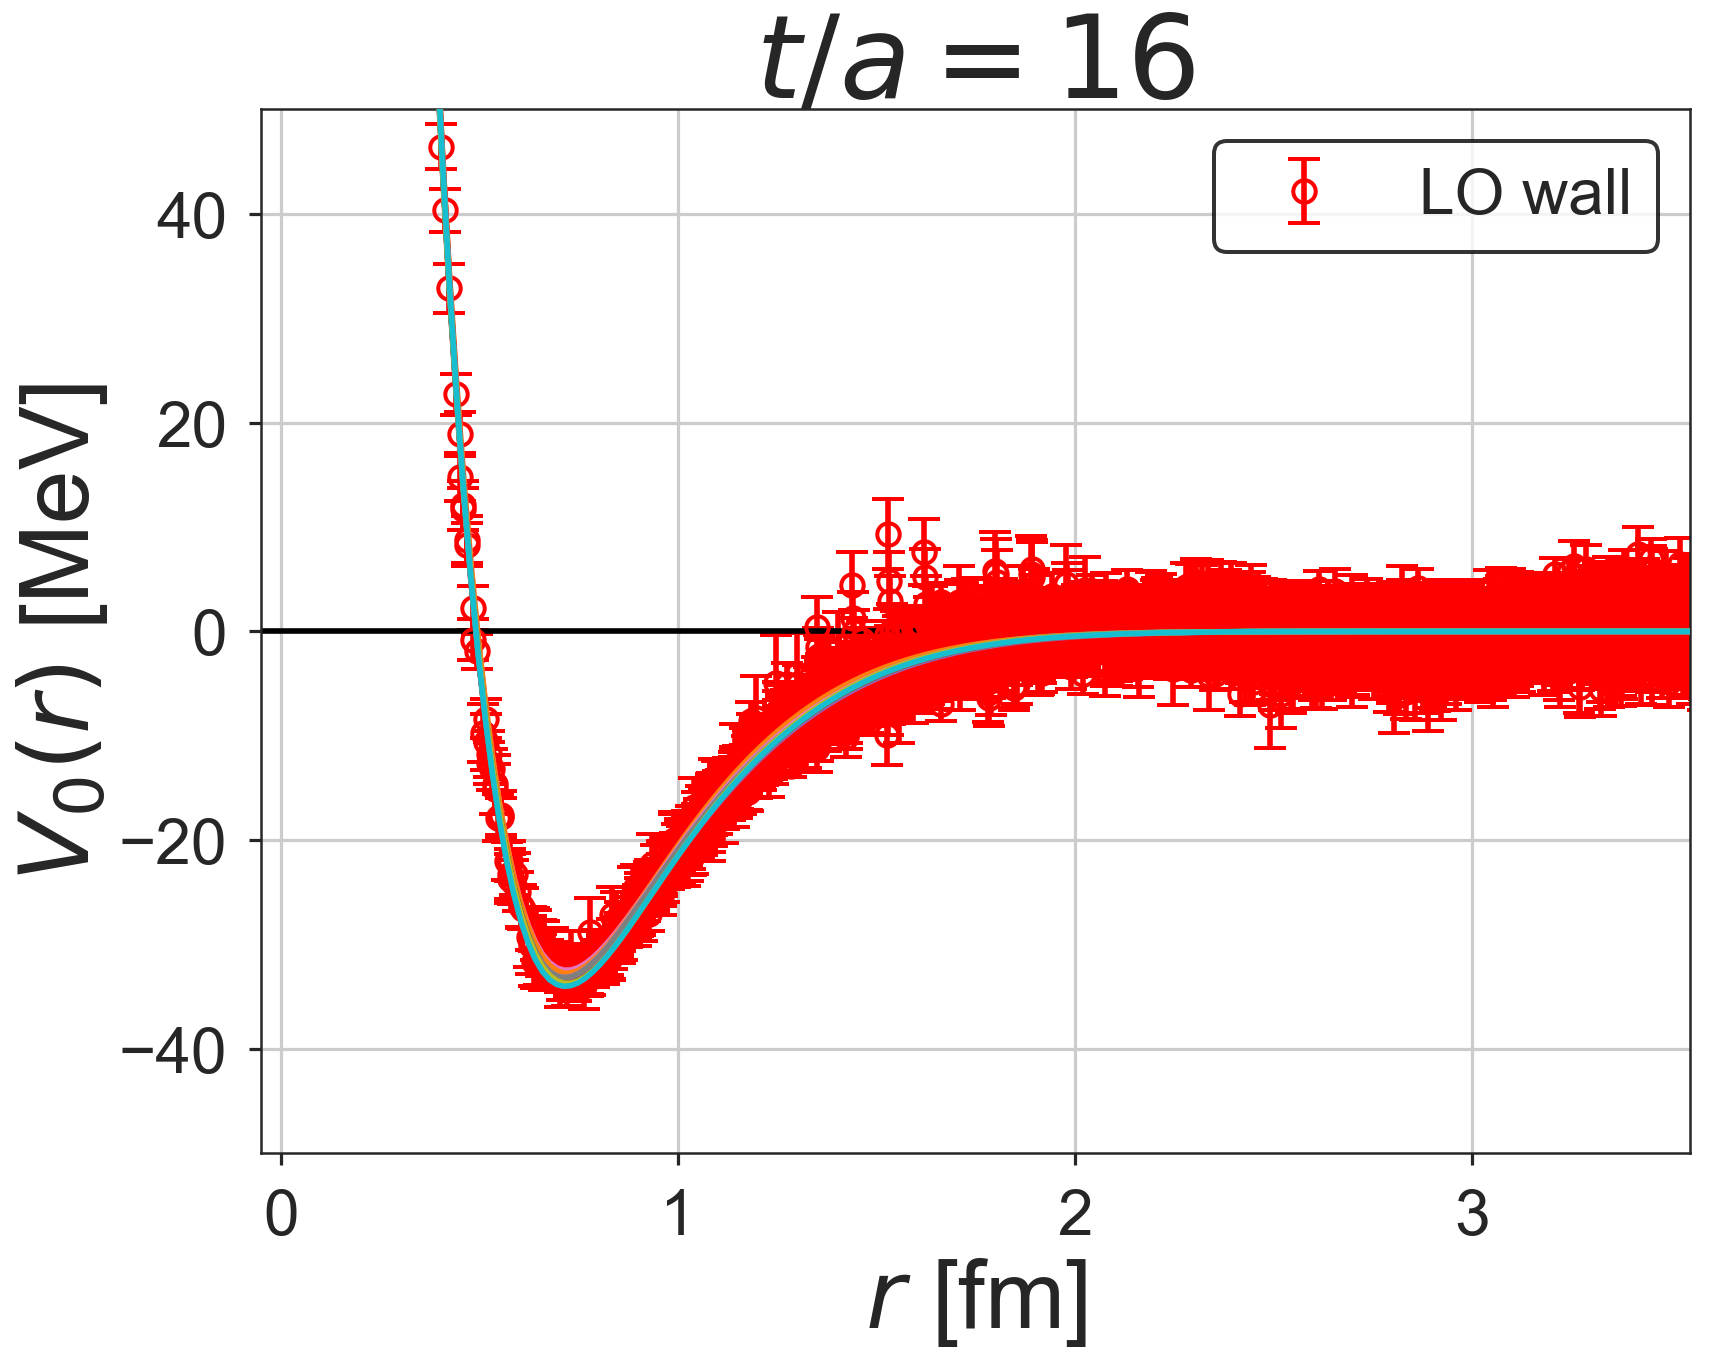

In [112]:
def check_v0_lo_fitting(it, src):
    fig, ax = plt.subplots()
    ax.errorbar(rs * lat_unit, 
                v0_lo_jk[src][it].mean(axis=0) * ainv, 
                v0_lo_jk[src][it].std(axis=0) * np.sqrt(bin_num - 1) * ainv,
                fmt='ro', mfc='none', mec='red', mew=2.0, capsize=8, capthick=2.0,
                label=f'LO {src}')

    p0 = prm_4gauss_avs[(src, it)]
    xls = np.linspace(1.0e-1, 40, 200)
    ax.plot(xls * lat_unit, V4gauss(p0,xls) * ainv, color='black', zorder=5) 

    for ibin in range(bin_num):
        p0 = prm_4gauss_jks[(src, it)][ibin,:]
        ax.plot(xls * lat_unit, V4gauss(p0,xls) * ainv, zorder=5) 

    ax.set_title(f'$t/a = {it}$', size=58)
    ax.grid()
    ax.set_ylim(-50, 50)
    ax.set_xlim(-0.05, 3.55)
    ax.axhline(0, color='black')
    ax.set_ylabel(r'$V_0(r)$ [MeV]', size=48)
    ax.set_xlabel(r'$r$ [fm]', size=48)

    leg = ax.legend(frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    
for it in [13, 14, 15, 16]:
    check_v0_lo_fitting(it, 'wall')

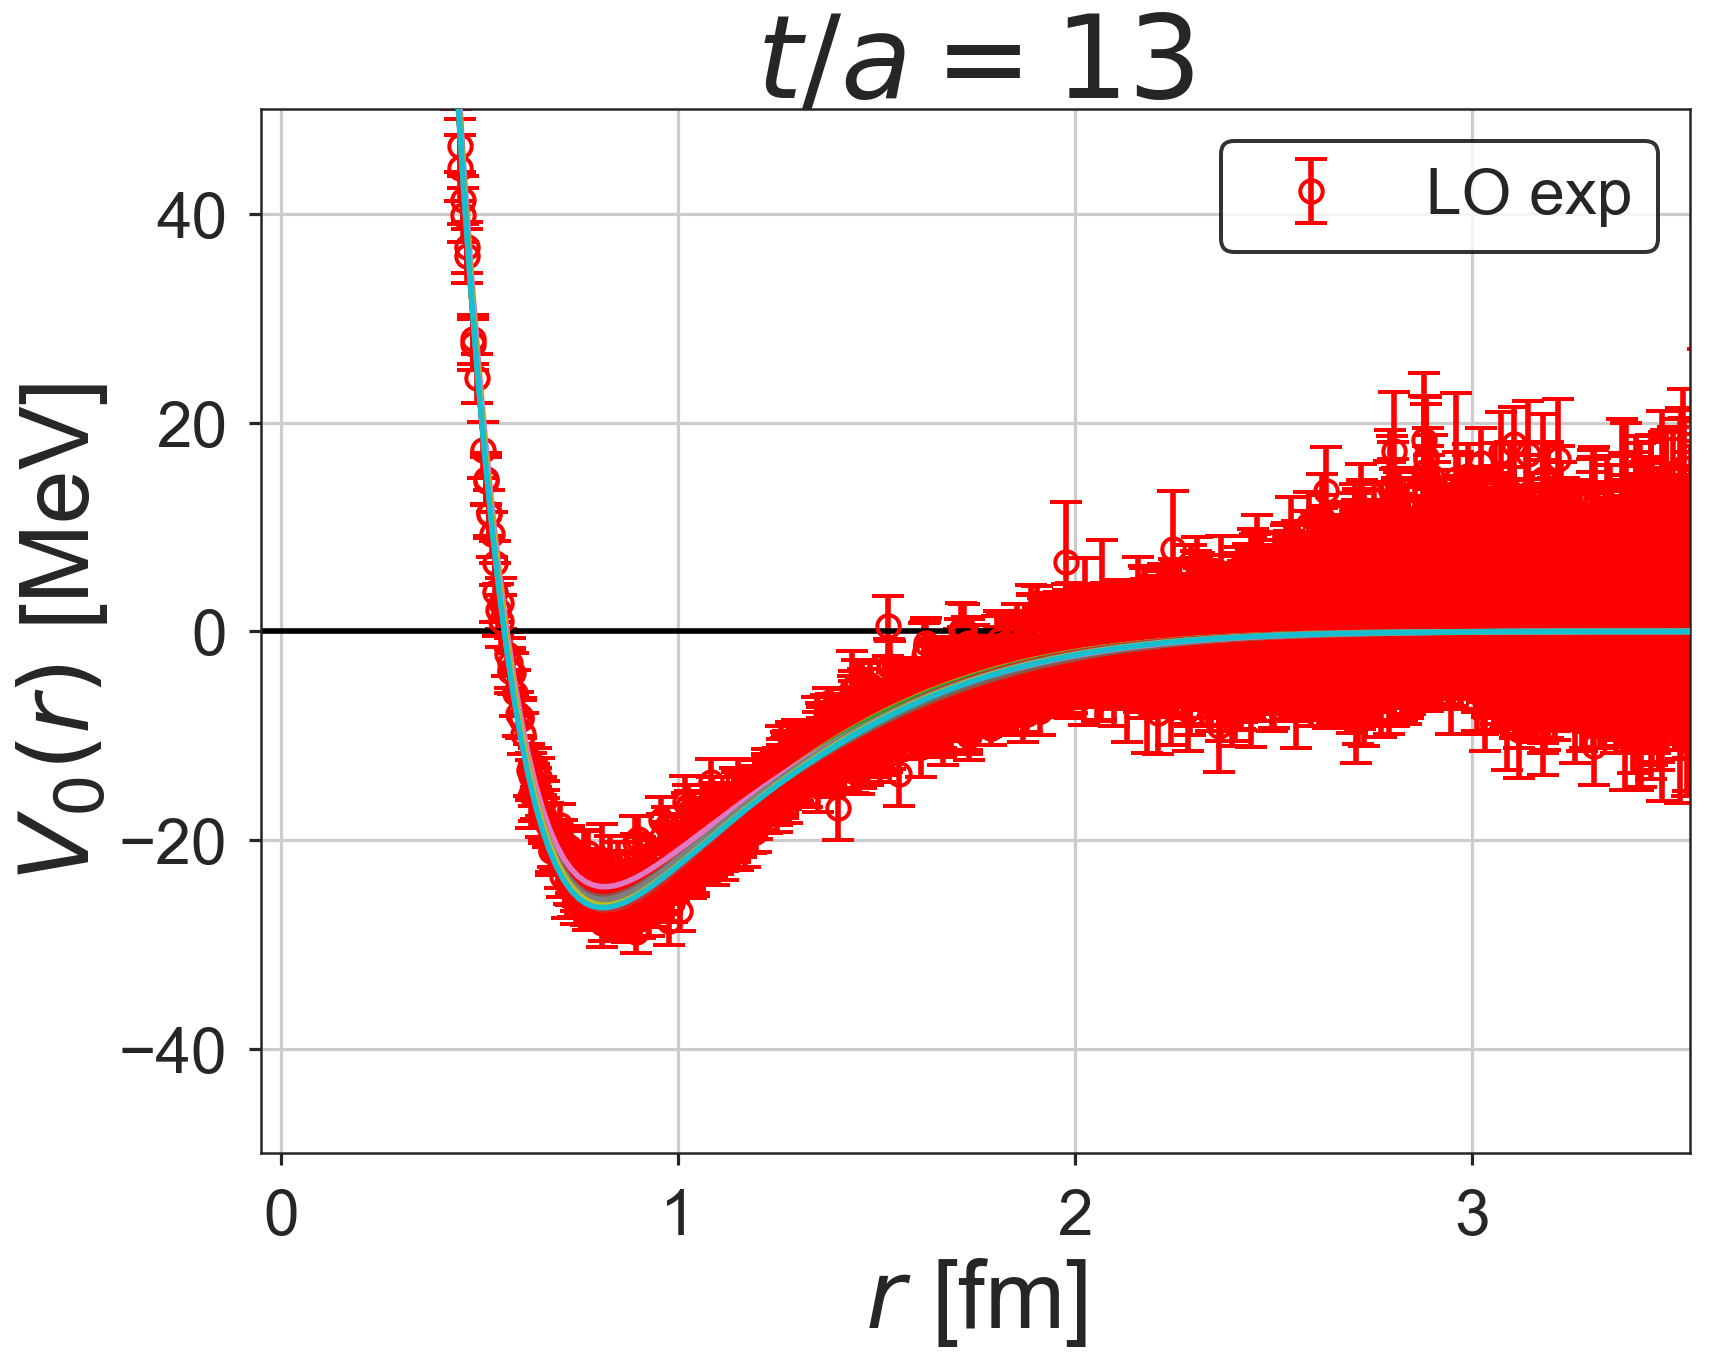

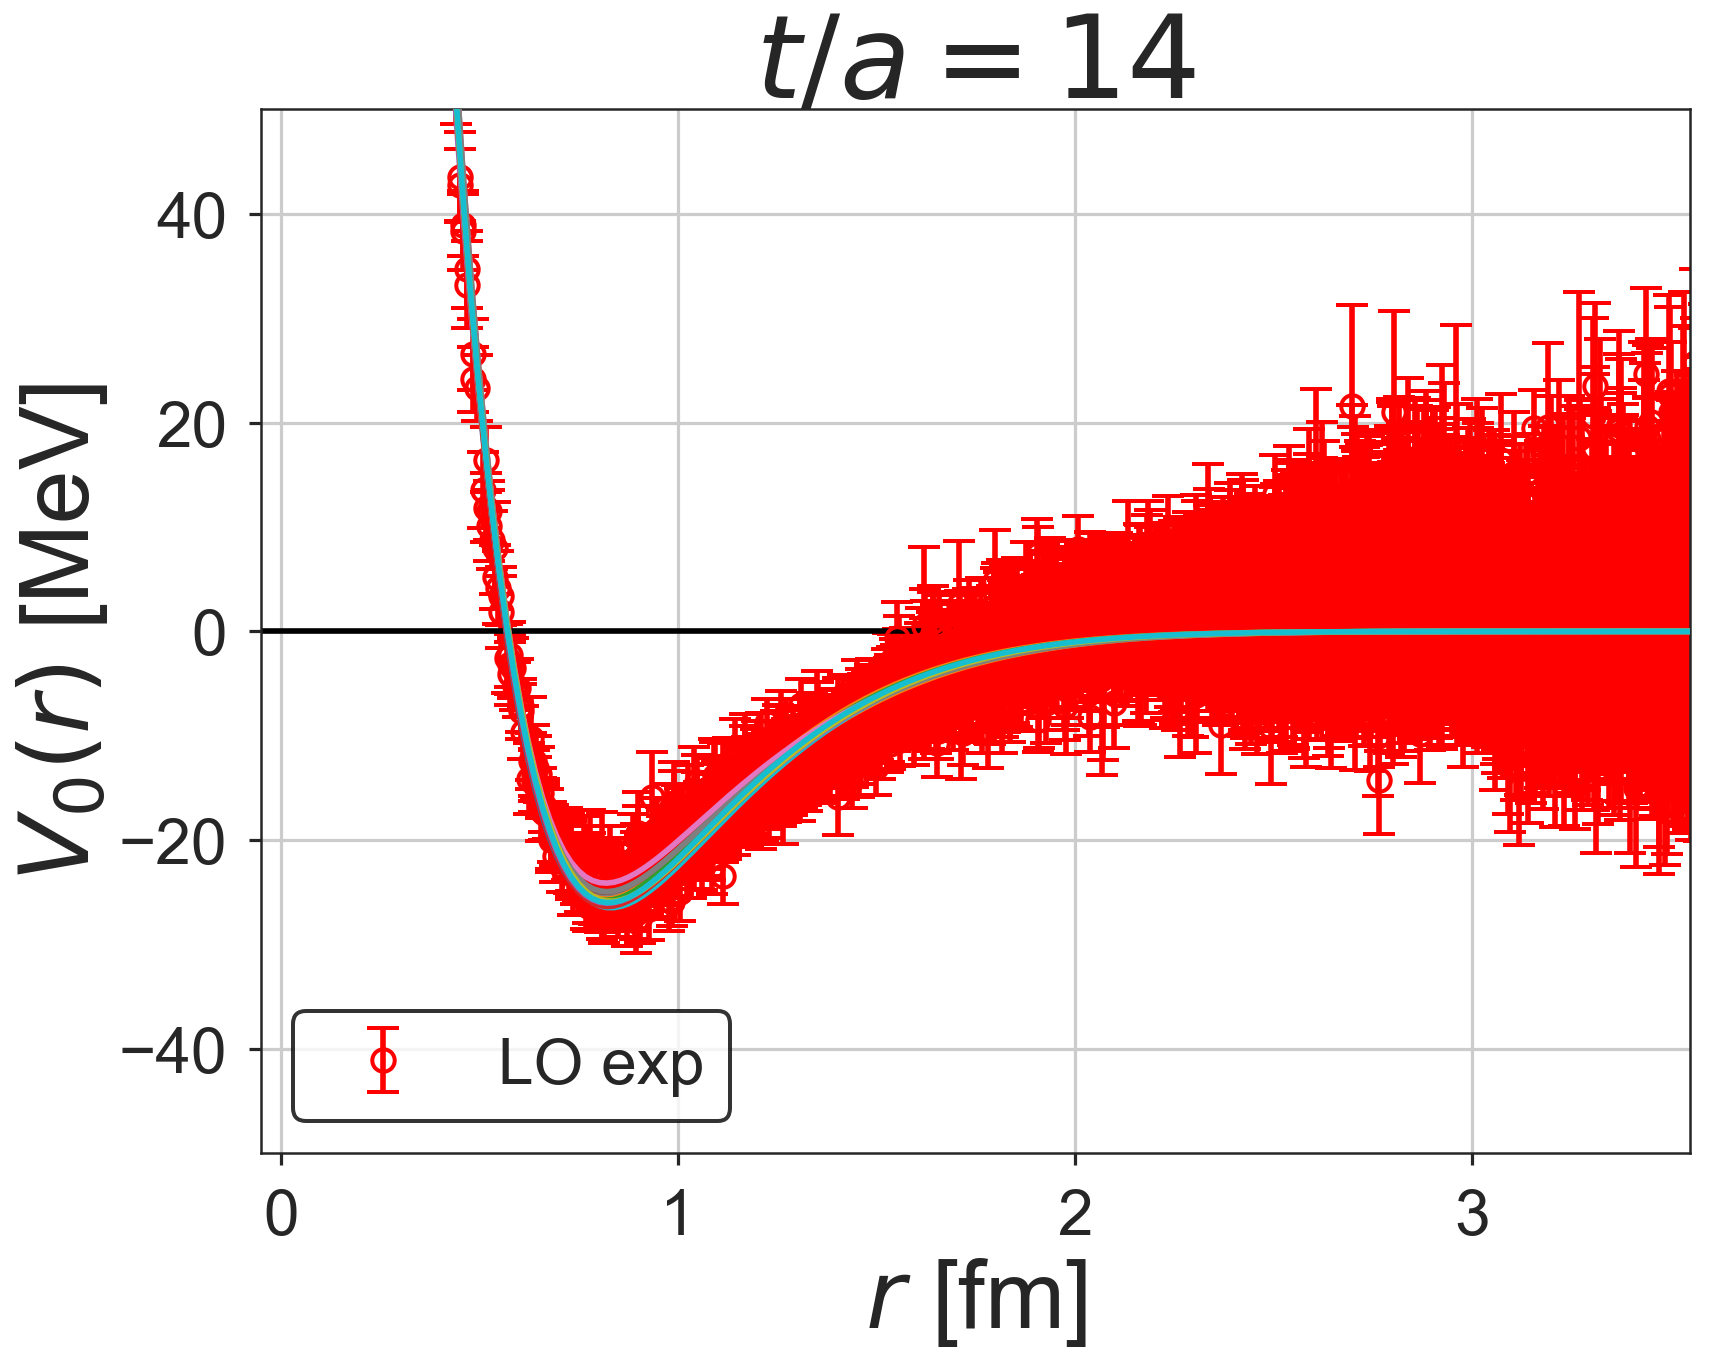

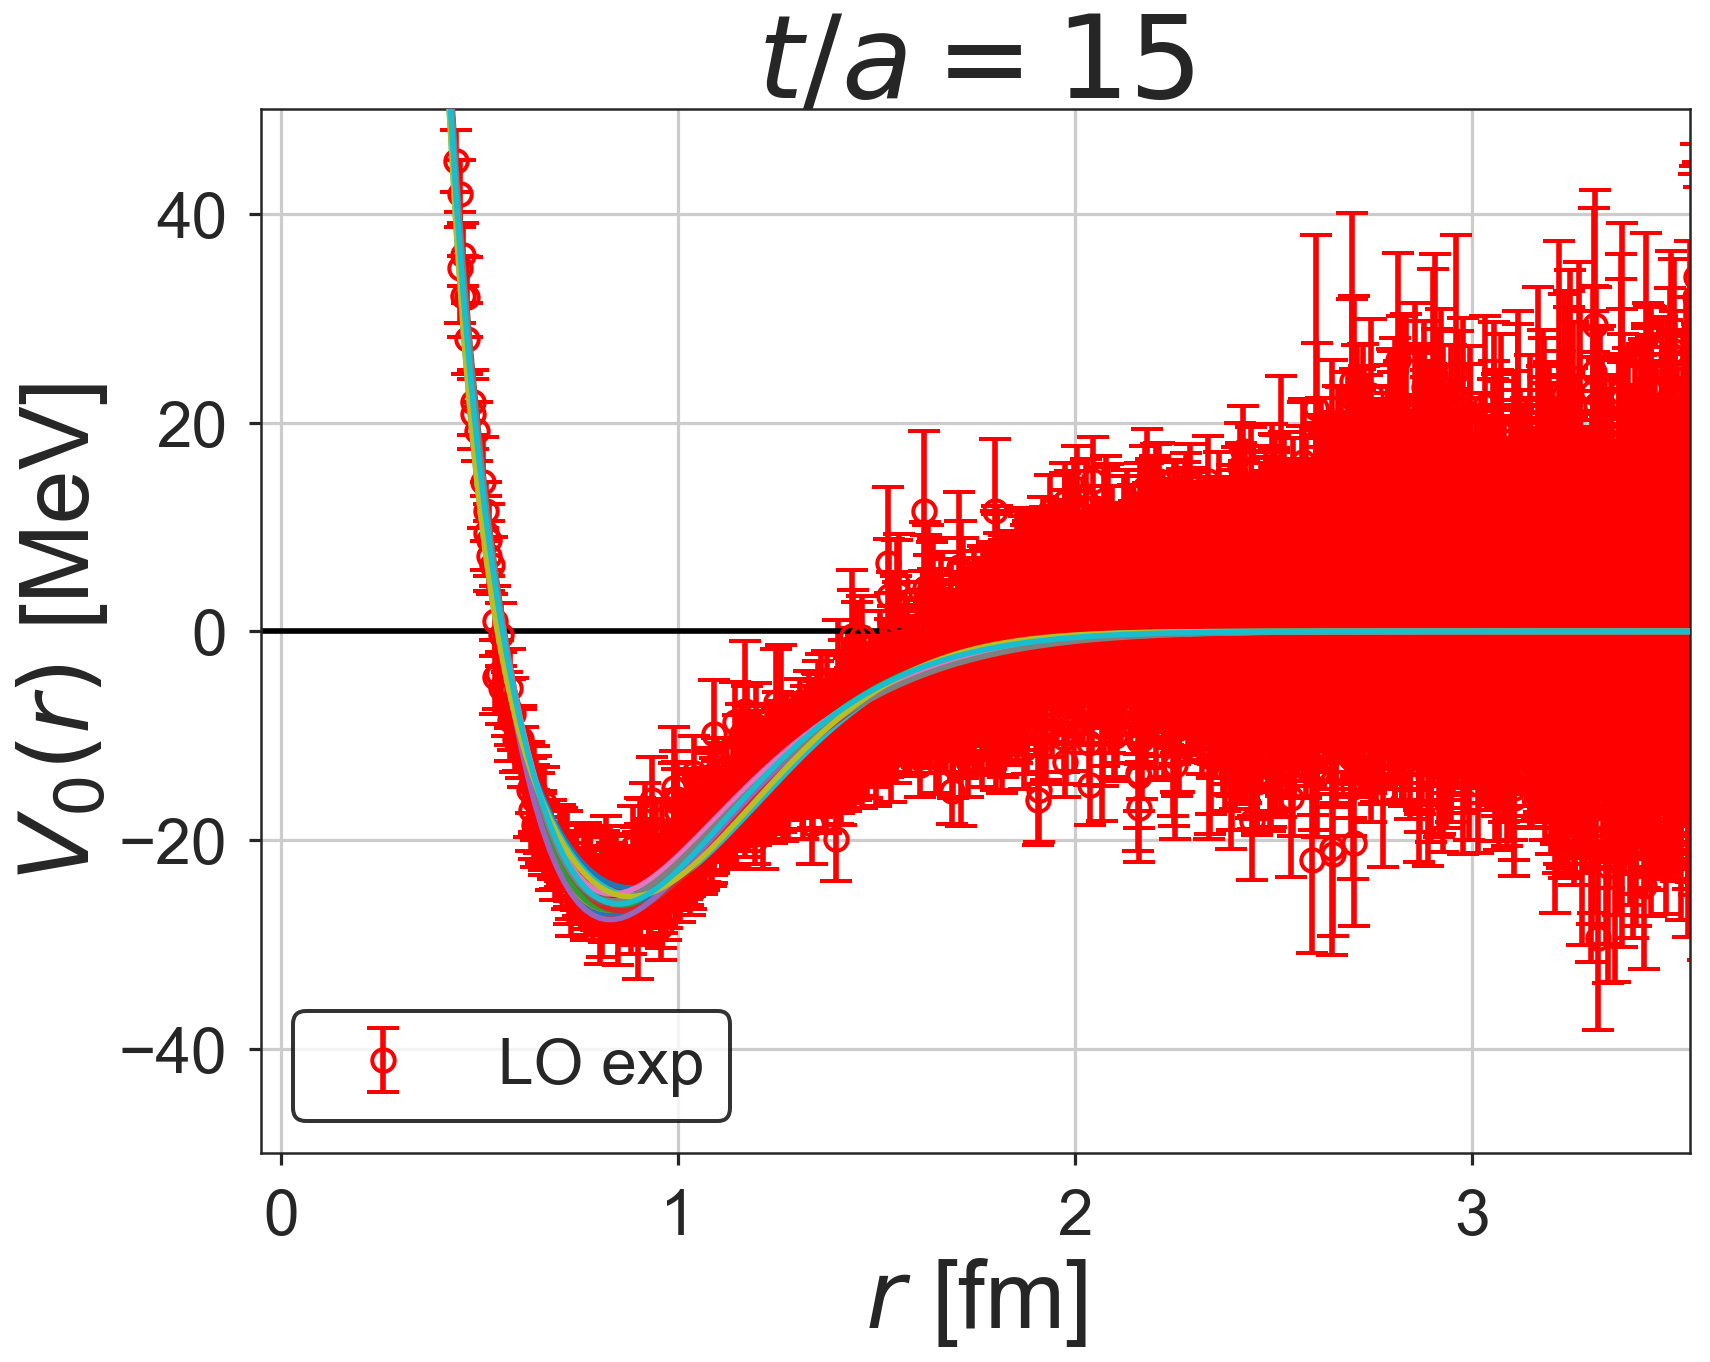

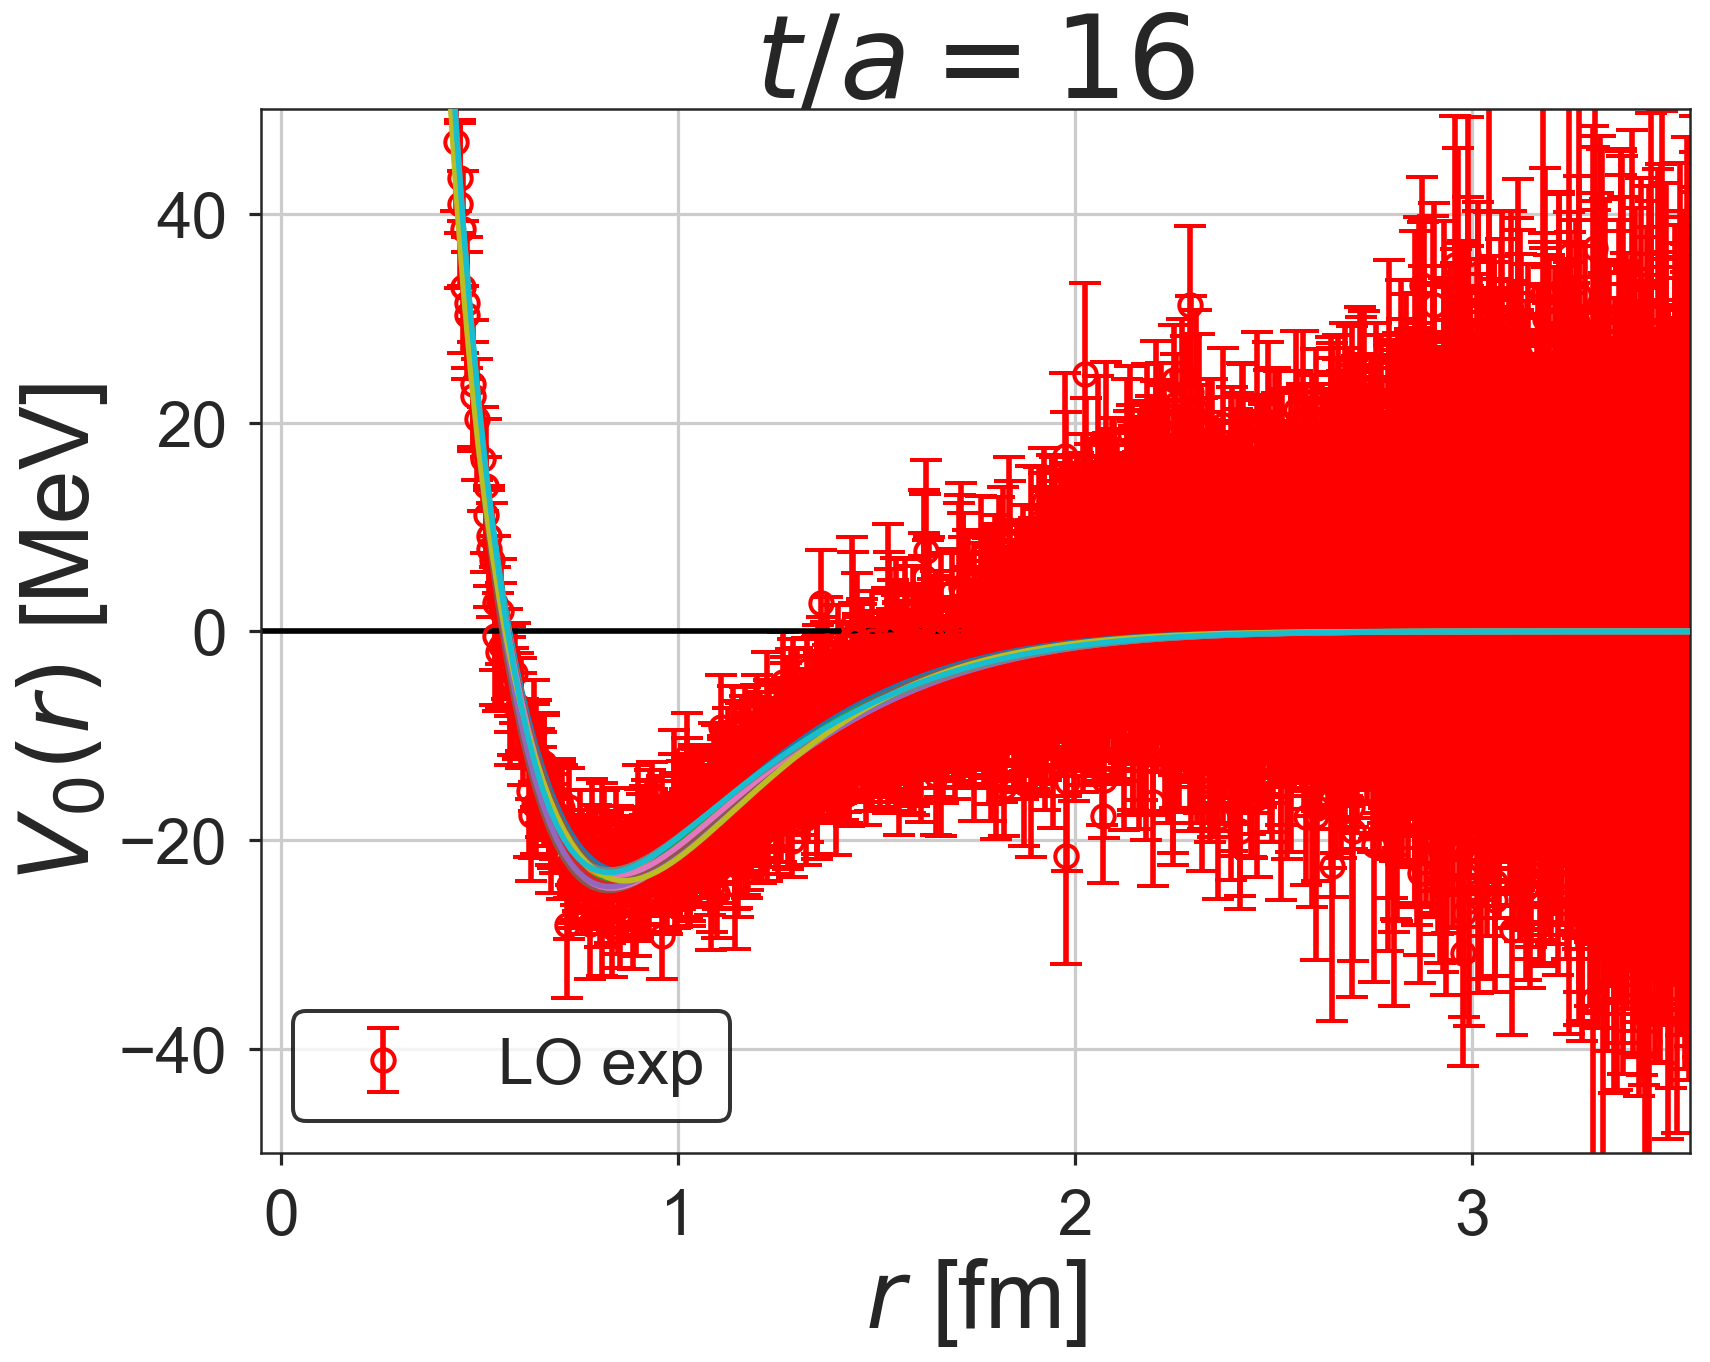

In [113]:
for it in [13, 14, 15, 16]:
    check_v0_lo_fitting(it, 'exp')

In [114]:
prm_4gauss_avs[('n2lo', 13)]

array([ 1.14258213,  0.93324502,  0.42448019,  0.23579594,  0.24146664,
        0.07875819, -0.03005393,  0.0091066 ])